In [1]:
from math import sqrt
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.impute import SimpleImputer
import plotly.express as px
from IPython.core.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Part B

This dataset contains computer price for different PC models, ranging from Apple, HP,
Dell, and others.

We want to build a machine learning model to predict the computer
price based on their configuration.
<br>

In [2]:
df = pd.read_csv('pc_data (regression).csv')
cpu = df['CPU']
gpu = df['GPU']
display(df.head())

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


## (A) Data Cleaning & Feature Engineering

In [3]:
df= df.drop(['Product ID'],axis=1)
display(df.head())

,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


### New Features
1. Screen
   1. DPI
   2. Aspect ratio
   3. Resolution
   4. Touchscreen
   5. TN or IPS
   6. Screen size

2. Laptop Brand

3. Laptop Type

4. GPU
   1. GPU Brand (Nvidia)
    - Default vs M vs MX vs GT vs GTX vs GTX MX vs Quadro gpu (find out purpose and document)
    - gpu generation
    - gpu quality

   2. GPU Brand (Intel)
    - Intel Graphics vs Intel HD vs Intel UHD vs Iris Plus vs Intel Iris Pro
    - gpu generation
    - gpu quality

   3. GPU Brand (AMD)
    - Radeon R# vs Radeon RX vs FirePro vs Radeon ##-Series vs Radeon Pro vs Radeon FX
    - gpu generation
    - gpu quality

5. Storage
    1. Base Storage Type (SSD or HDD or Flash Storage)
    2. Upgraded Storage (Yes or No)
        - SSD or HDD
        - Therefore, max storage

6. RAM

7. Operating System



### Brand Feature Engineering

In [4]:
# count number of laptop models per brand
print(df['Brand'].value_counts())


Lenovo       3532
Dell         3492
HP           3228
Asus         1844
Acer         1204
MSI           640
Toshiba       576
Apple         200
Samsung       108
Razer          84
Mediacom       84
Microsoft      68
Xiaomi         48
Vero           48
Google         36
Fujitsu        36
LG             36
Chuwi          32
Huawei         24
Name: Brand, dtype: int64


### Screen Feature Engineering

Extracting:
1. IPS Availability
2. Touchscreen Capabilities
3. Screen Resolution
4. Screen Aspect Ratio & DPI

In [5]:
# Feature Engineering Screen data

## 1. IPS Availability
df['IPS Check'] = df['Screen Specs'].str.contains('IPS',case=False).astype('str')
df['IPS Check'] = df['IPS Check'].str.replace('False','TN Screen')
df['IPS Check'] = df['IPS Check'].str.replace('True','IPS Screen')

## 2. Touchscreen Capabilities
df['Touchscreen Check'] = df['Screen Specs'].str.contains('Touchscreen',case=False).astype('str')
df['Touchscreen Check'] = df['Touchscreen Check'].str.replace('False','No Touchscreen')
df['Touchscreen Check'] = df['Touchscreen Check'].str.replace('True','Touchscreen Available')

## 3. Screen Resolution
df['Screen Specs'] = df['Screen Specs'].str.replace('4K','')
df['Screen Width']=df['Screen Specs'].str.extract(r'(\d+)').astype(int)
df['Screen Height']=df['Screen Specs'].str.extract(r'(x\d+)')
df['Screen Height'] = df['Screen Height'].str.replace('x','').astype(int)

## 4. Screen Aspect Ratio & DPI
df['Aspect Ratio'] = df['Screen Width']/df['Screen Height']
df['Screen DPI'] = np.sqrt((df['Screen Width'])**2+(df['Screen Height'])**2)/df['Screen Size']

## Feature engineering qualitative data for categorical features/variables
def res_check(row):
    if row['Screen Width'] * row['Screen Height'] < 1200000 :
        val = 'HD'
    elif 1200000 < row['Screen Width'] * row['Screen Height'] < 2200000:
        val = 'Full HD'
    elif 2200000 < row['Screen Width'] * row['Screen Height'] < 6000000:
        val = 'Quad HD'
    elif row['Screen Width'] * row['Screen Height'] > 7900000:
        val = 'Ultra HD'
    else:
        val = None
    return val

df['Resolution Type'] = df.apply(res_check,axis=1)


df = df[['Brand', 'Type', 'Screen Size', 'Screen Specs', 'Touchscreen Check','IPS Check', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI','Resolution Type','CPU', 'RAM', 'Hard Disk', 'GPU', 'Operating System', 'Weight', 'Price ($)']]



### CPU Feature Engineering
Extracting:
1. CPU Brand
2. CPU Brand Series / version
3. CPU Series Performance Type
4. CPU Series Generation
5. CPU Base Clock
6. CPU Core Count

In [6]:
# Feature Engineering CPU

## 1. CPU Brand
def cpu_brand(row):
    if 'AMD' in row['CPU']:
        val = 'AMD'
    elif 'Intel' in row['CPU']:
        val = 'Intel'

    else:
        val = None
    return val

df['CPU Brand']= df.apply(cpu_brand,axis=1)


## 2. CPU Brand Series / version
### AMD
df['AMD A Series'] = df['CPU'].str.extract(r'(AMD [a-zA-Z]\d{1,2})').astype('str')
df['AMD A Series'].replace('nan', np.nan,inplace=True)

df['AMD E Series'] = df['CPU'].str.extract(r'(AMD E-Series \d)').astype('str')
df['AMD E Series'] = df['AMD E Series'].str.replace('-Series ','',regex=True,case=False)
df['AMD E Series'].replace('nan', np.nan,inplace=True)

df['AMD FX Series'] = df['CPU'].str.extract(r'([FX]{2} \d{1})').astype('str')
df['AMD FX Series'] = df['AMD FX Series'].str.replace('FX ','AMD FX ',regex=True,case=False)
df['AMD FX Series'].replace('nan', np.nan,inplace=True)

df['AMD Ryzen Series'] = df['CPU'].str.extract(r'(Ryzen \d{4})').astype('str')
df['AMD Ryzen Series'] = df['AMD Ryzen Series'].str.replace('Ryzen 1600','Ryzen 5',regex=True,case=False)
df['AMD Ryzen Series'] = df['AMD Ryzen Series'].str.replace('Ryzen 1700','Ryzen 7',regex=True,case=False)
df['AMD Ryzen Series'].replace('nan', np.nan,inplace=True)

### Intel
df['Intel Atom Series'] = df['CPU'].str.extract(r'(Atom [a-zA-Z]{1}\d{1}-[a-zA-Z]{1}\d{4}|Atom [a-zA-Z]{1}\d{4})').astype('str')
df['Intel Atom Series'] = df['Intel Atom Series'].str.replace('X5-','',regex=True,case=False)
df['Intel Atom Series'].replace('nan', np.nan,inplace=True)

df['Intel Celeron Series'] = df['CPU'].str.extract(r'(Celeron [a-zA-Z]{1,5} Core [a-zA-Z]{1}\d{4}|Celeron [a-zA-Z]{1,5} Core \d{4}[a-zA-Z]{1})').astype('str')
df['Intel Celeron Series'] = df['Intel Celeron Series'].str.replace('[a-zA-Z]{1,5} Core','',regex=True,case=False)
df['Intel Celeron Series'] = df['Intel Celeron Series'].str.replace('Celeron ','Celeron',regex=True,case=False)
df['Intel Celeron Series'] = df['Intel Celeron Series'].str.replace('Celeron \d{4}U','Celeron U',regex=True,case=False)
df['Intel Celeron Series'] = df['Intel Celeron Series'].str.replace('Celeron N\d{4}','Celeron N',regex=True,case=False)
df['Intel Celeron Series'].replace('nan', np.nan,inplace=True)

df['Intel Core M Series'] = df['CPU'].str.extract(r'(Core M [a-zA-Z]\d{1}-\d{1}|Core M [a-zA-Z]\d{1}|Core M|Core M \d{1}[a-zA-Z]{1}\d{1}\d{1})').astype('str')
df['Intel Core M Series'] = df['Intel Core M Series'].str.replace('m','M',regex=True,case=True)
df['Intel Core M Series'].replace('nan', np.nan,inplace=True)

df['Intel Core Series'] = df['CPU'].str.extract(r'(Intel Core [a-zA-Z]\d{1})').astype('str')
df['Intel Core Series'] = df['Intel Core Series'].str.replace('Intel Core ','',regex=True,case=True)
df['Intel Core Series'].replace('nan', np.nan,inplace=True)

df['Intel Core Series Generation'] = df['CPU'].str.extract(r'(Intel Core [a-zA-Z]\d{1} [5-9]{1})').astype('str')
df['Intel Core Series Generation'] = df['Intel Core Series Generation'].str.replace('Intel Core [a-zA-Z][2-9]{1} ','',regex=True,case=True)
df['Intel Core Series Generation'] = df['Intel Core Series Generation'].apply(lambda x:  "{}{}".format(x,'th gen') if x!='nan' else x)
df['Intel Core Series Generation'].replace('nan', np.nan,inplace=True)


## 3. CPU Series Performance Type
df['Intel Core Series Performance Type'] = df['CPU'].str.extract(r'([a-zA-Z]\d \d{4}[a-zA-Z]{1,2}|[a-zA-Z]\d \dY)').astype('str')
df['Intel Core Series Performance Type'] = df['Intel Core Series Performance Type'].str.replace('[a-zA-Z]\d \d{4}','',regex=True,case=True)
df['Intel Core Series Performance Type'] = df['Intel Core Series Performance Type'].str.replace('[a-zA-Z]\d \d{1}','',regex=True,case=True)
df['Intel Core Series Performance Type'].replace('nan', np.nan,inplace=True)

df['Intel Pentium Core Type'] = df['CPU'].str.extract(r'(Intel Pentium [a-zA-Z]{1,5} Core \d{4}[a-zA-Z]{1}|Intel Pentium [a-zA-Z]{1,5} Core [a-zA-Z]{1})').astype('str')
df['Intel Pentium Core Type'] = df['Intel Pentium Core Type'].str.replace('Intel Pentium [a-zA-Z]{1,5} Core \d{4}','',regex=True,case=True)
df['Intel Pentium Core Type'] = df['Intel Pentium Core Type'].str.replace('Intel Pentium [a-zA-Z]{1,5} Core ','',regex=True,case=True)
df['Intel Pentium Core Type'] = df['Intel Pentium Core Type'].apply(lambda x:  "{}{}".format('Pentium ',x,) if x!='nan' else x)
df['Intel Pentium Core Type'].replace('nan', np.nan,inplace=True)


## 4. CPU Series Generation
df['Intel Pentium Core Generation'] = df['CPU'].str.extract(r'(Pentium [a-zA-Z]{4} Core \d{1}|Pentium [a-zA-Z]{4} Core [a-zA-Z]{1}\d{1})').astype('str')
df['Intel Pentium Core Generation'] = df['Intel Pentium Core Generation'].str.replace('Pentium [a-zA-Z]{4} Core N','',regex=True,case=True)
df['Intel Pentium Core Generation'] = df['Intel Pentium Core Generation'].str.replace('Pentium [a-zA-Z]{4} Core ','',regex=True,case=True)
df['Intel Pentium Core Generation'] = df['Intel Pentium Core Generation'].apply(lambda x:  "{}{}".format(x,"th gen") if x!='nan' and x!='3' else x)
df['Intel Pentium Core Generation'] = df['Intel Pentium Core Generation'].apply(lambda x:  "{}{}".format(x,"rd gen") if x!='nan' and x=='3' else x)
df['Intel Pentium Core Generation'].replace('nan', np.nan,inplace=True)

df['Intel Xeon Version'] = df['CPU'].str.extract(r'(Intel Xeon E3-\d{4}[a-zA-Z]{1} [a-zA-Z]{1}\d{1})').astype('str')
df['Intel Xeon Version'] = df['Intel Xeon Version'].str.replace('Intel Xeon E3-\d{4}[a-zA-Z]{1} [a-zA-Z]{1}','',regex=True,case=True)
df['Intel Xeon Version'] = df['Intel Xeon Version'].apply(lambda x:  "{}{}{}".format('Xeon ',x,"th gen") if x!='nan' else x)
df['Intel Xeon Version'].replace('nan', np.nan,inplace=True)


## 5. CPU Base Clock
df['CPU Base Clock'] = df['CPU'].str.extract(r'(\d*\.?\d+)GHz')


## 6. CPU Core Count
def core_count(row):
    if row['AMD A Series'] == 'AMD A10':
        val = '4 Cores'
    elif row['AMD A Series'] == 'AMD A4':
        val = '4 Cores'
    elif row['AMD A Series'] == 'AMD A6':
        val = '2 Cores'
    elif row['AMD A Series'] == 'AMD A8':
        val = '4 Cores'
    elif row['AMD A Series'] == 'AMD A9':
        val = '2 Cores'
    elif row['AMD A Series'] == 'AMD A12':
        val = '4 Cores'
    elif row['AMD E Series'] == 'AMD E6':
        val = '2 Cores'
    elif row['AMD E Series'] == 'AMD E7':
        val = '2 Cores'
    elif row['AMD E Series'] == 'AMD E9':
        val = '4 Cores'
    elif row['AMD FX Series'] == 'AMD FX 8':
        val = '8 Cores'
    elif row['AMD FX Series'] == 'AMD FX 9':
        val = '8 Cores'
    elif row['AMD Ryzen Series'] == 'Ryzen 5':
        val = '4 Cores'
    elif row['AMD Ryzen Series'] == 'Ryzen 7':
        val = '6 Cores'
    elif row['Intel Atom Series'] == 'Atom Z8300':
        val = '2 Cores'
    elif row['Intel Atom Series'] == 'Atom Z8350':
        val = '2 Cores'
    elif row['Intel Atom Series'] == 'Atom Z8550':
        val = '2 Cores'
    elif row['Intel Celeron Series'] == 'Celeron N':
        val = '2 Cores'
    elif row['Intel Celeron Series'] == 'Celeron U':
        val = '2 Cores'
    elif row['Intel Core M Series'] == 'Core M M3-7':
        val = '2 Cores'
    elif row['Intel Core M Series'] == 'Core M':
        val = '2 Cores'
    elif row['Intel Core M Series'] == 'Core M M3':
        val = '2 Cores'
    elif row['Intel Core M Series'] == 'Core M M3-6':
        val = '2 Cores'
    elif row['Intel Core M Series'] == 'Core M M7-6':
        val = '2 Cores'
    elif row['Intel Core Series'] == 'i3':
        val = '2 Cores'
    elif row['Intel Core Series'] == 'i5':
        val = '4 Cores'
    elif row['Intel Core Series'] == 'i7':
        val = '6 Cores'
    elif row['Intel Pentium Core Type'] == 'Pentium N':
        val = '4 Cores'
    elif row['Intel Pentium Core Type'] == 'Pentium U':
        val = '4 Cores'
    elif row['Intel Pentium Core Type'] == 'Pentium Y':
        val = '4 Cores'
    elif row['Intel Xeon Version'] == 'Xeon 5th gen':
        val = '4 Cores'
    elif row['Intel Xeon Version'] == 'Xeon 6th gen':
        val = '4 Cores'
    else:
        val = None
    return val

df['Core Count'] = df.apply(core_count,axis=1).astype('str')

df = df[df['Core Count']!='None']


df = df[['Brand', 'Type', 'Screen Size', 'Touchscreen Check', 'IPS Check', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'Resolution Type', 'CPU Base Clock', 'Core Count','CPU', 'CPU Brand','AMD A Series', 'AMD E Series', 'AMD FX Series', 'AMD Ryzen Series', 'Intel Atom Series', 'Intel Celeron Series', 'Intel Core M Series', 'Intel Core Series', 'Intel Core Series Generation', 'Intel Core Series Performance Type', 'Intel Pentium Core Type', 'Intel Pentium Core Generation', 'Intel Xeon Version', 'RAM', 'Hard Disk', 'GPU', 'Operating System', 'Weight', 'Price ($)']]

# defining column types
df['Screen Size'] =df['Screen Size'].astype('float')
df['Touchscreen Check'] =df['Touchscreen Check'].astype('str')
df['IPS Check'] =df['IPS Check'].astype('str')
df['Screen Width'] =df['Screen Width'].astype('int')
df['Screen Height'] =df['Screen Height'].astype('int')
df['Aspect Ratio'] =df['Aspect Ratio'].astype('float')
df['Screen DPI'] =df['Screen DPI'].astype('float')
df['CPU Base Clock'] =df['CPU Base Clock'].astype('float')


# concatenating the columns together for encoding
df['AMD Series'] = df['AMD A Series'].fillna(df['AMD E Series'])
df['AMD Series'] = df['AMD Series'].fillna(df['AMD FX Series'])
df['AMD Series'] = df['AMD Series'].fillna(df['AMD Ryzen Series'])
df = df.drop(['AMD Ryzen Series','AMD FX Series','AMD E Series','AMD A Series'],axis=1)

df['Intel Series'] = df['Intel Atom Series'].combine_first(df['Intel Celeron Series'])
df['Intel Series'] = df['Intel Series'].combine_first(df['Intel Core M Series'])
df['Intel Series'] = df['Intel Series'].combine_first(df['Intel Core Series'])
df['Intel Series'] = df['Intel Series'].combine_first(df['Intel Pentium Core Type'])
df['Intel Series'] = df['Intel Series'].combine_first(df['Intel Xeon Version'])

df['Intel Generation'] = df['Intel Core Series Generation'].combine_first(df['Intel Pentium Core Generation']).astype('str')
df['Intel Generation'].replace('nan', np.nan,inplace=True)

df['Intel Core Series Performance Type'] = df['Intel Core Series Performance Type'].astype('str')
df['Intel Core Series Performance Type'].replace('nan', np.nan,inplace=True)


# additional dataframe column cleaning
df = df.drop(['Intel Celeron Series','Intel Atom Series','Intel Core M Series','Intel Core Series','Intel Pentium Core Type'],axis=1)
df['CPU Series'] = df['AMD Series'].fillna(df['Intel Series'])
df = df.drop(['AMD Series','Intel Series'],axis=1)


display(df)

,Brand,Type,Screen Size,Touchscreen Check,IPS Check,Screen Width,Screen Height,Aspect Ratio,Screen DPI,Resolution Type,CPU Base Clock,Core Count,CPU,CPU Brand,Intel Core Series Generation,Intel Core Series Performance Type,Intel Pentium Core Generation,Intel Xeon Version,RAM,Hard Disk,GPU,Operating System,Weight,Price ($),Intel Generation,CPU Series
0,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,2.3,4 Cores,Intel Core i5 2.3GHz,Intel,NaN,NaN,NaN,NaN,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416,NaN,i5
1,Apple,Ultrabook,13.3,No Touchscreen,TN Screen,1440,900,1.600000,127.677940,Full HD,1.8,4 Cores,Intel Core i5 1.8GHz,Intel,NaN,NaN,NaN,NaN,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616,NaN,i5
2,HP,Notebook,15.6,No Touchscreen,TN Screen,1920,1080,1.777778,141.211998,Full HD,2.5,4 Cores,Intel Core i5 7200U 2.5GHz,Intel,7th gen,U,NaN,NaN,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000,7th gen,i5
3,Apple,Ultrabook,15.4,No Touchscreen,IPS Screen,2880,1800,1.600000,220.534624,Quad HD,2.7,6 Cores,Intel Core i7 2.7GHz,Intel,NaN,NaN,NaN,NaN,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680,NaN,i7
4,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,3.1,4 Cores,Intel Core i5 3.1GHz,Intel,NaN,NaN,NaN,NaN,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040,NaN,i5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,Lenovo,2 in 1 Convertible,14.0,Touchscreen Available,IPS Screen,1920,1080,1.777778,157.350512,Full HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200,6th gen,i7
15316,Lenovo,2 in 1 Convertible,13.3,Touchscreen Available,IPS Screen,3200,1800,1.777778,276.053530,Quad HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600,6th gen,i7
15317,Lenovo,Notebook,14.0,No Touchscreen,TN Screen,1366,768,1.778646,111.935204,HD,1.6,2 Cores,Intel Celeron Dual Core N3050 1.6GHz,Intel,NaN,NaN,NaN,NaN,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,616.82600,NaN,Celeron N
15318,HP,Notebook,15.6,No Touchscreen,TN Screen,1366,768,1.778646,100.454670,HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600,6th gen,i7


### RAM Feature Engineering

Extracting the integer from the string as quantitative variable

In [7]:
 # feature engineering RAM

df['RAM'] = df['RAM'].str.replace('GB','',regex=True,case=True)
df['RAM'] =df['RAM'].astype('int')


In [8]:
display(df)

,Brand,Type,Screen Size,Touchscreen Check,IPS Check,Screen Width,Screen Height,Aspect Ratio,Screen DPI,Resolution Type,CPU Base Clock,Core Count,CPU,CPU Brand,Intel Core Series Generation,Intel Core Series Performance Type,Intel Pentium Core Generation,Intel Xeon Version,RAM,Hard Disk,GPU,Operating System,Weight,Price ($),Intel Generation,CPU Series
0,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,2.3,4 Cores,Intel Core i5 2.3GHz,Intel,NaN,NaN,NaN,NaN,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416,NaN,i5
1,Apple,Ultrabook,13.3,No Touchscreen,TN Screen,1440,900,1.600000,127.677940,Full HD,1.8,4 Cores,Intel Core i5 1.8GHz,Intel,NaN,NaN,NaN,NaN,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616,NaN,i5
2,HP,Notebook,15.6,No Touchscreen,TN Screen,1920,1080,1.777778,141.211998,Full HD,2.5,4 Cores,Intel Core i5 7200U 2.5GHz,Intel,7th gen,U,NaN,NaN,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000,7th gen,i5
3,Apple,Ultrabook,15.4,No Touchscreen,IPS Screen,2880,1800,1.600000,220.534624,Quad HD,2.7,6 Cores,Intel Core i7 2.7GHz,Intel,NaN,NaN,NaN,NaN,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680,NaN,i7
4,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,3.1,4 Cores,Intel Core i5 3.1GHz,Intel,NaN,NaN,NaN,NaN,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040,NaN,i5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,Lenovo,2 in 1 Convertible,14.0,Touchscreen Available,IPS Screen,1920,1080,1.777778,157.350512,Full HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200,6th gen,i7
15316,Lenovo,2 in 1 Convertible,13.3,Touchscreen Available,IPS Screen,3200,1800,1.777778,276.053530,Quad HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600,6th gen,i7
15317,Lenovo,Notebook,14.0,No Touchscreen,TN Screen,1366,768,1.778646,111.935204,HD,1.6,2 Cores,Intel Celeron Dual Core N3050 1.6GHz,Intel,NaN,NaN,NaN,NaN,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,616.82600,NaN,Celeron N
15318,HP,Notebook,15.6,No Touchscreen,TN Screen,1366,768,1.778646,100.454670,HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,6th gen,U,NaN,NaN,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600,6th gen,i7


### Storage Feature Engineering

Extracting:
1. Base & Additional Storage Capabilities
2. Base & Additional Storage Space
3. Base & Additional Storage Size Format
4. Base & Additional Storage Type

In [9]:
# feature engineering hard disk
print(np.unique(df['Hard Disk']))

# splitting into base and additional
df[['Base Storage','Additional Storage']] =df['Hard Disk'].str.split('+',expand=True).astype('str')
df['Additional Storage'] =df['Additional Storage'].str.replace('  ','',regex=True)
df['Additional Storage'].replace('nan', np.nan,inplace=True)



## base storage space number (128, 256, 1)
df['Base Storage Space Value'] = df['Base Storage'].str.extract(r'(\d*\.\d{1,4}|\d{1,3})').astype('str')
df['Base Storage Space Value'] = df['Base Storage Space Value'].str.replace('1.0','1',regex=False).astype('int')


## base storage size type (GB,TB)
df['Base Storage Size Type'] = df['Base Storage'].str.extract(r'(\d*\.\d{1,4}[A-Z]{2}|\d{1,3}[A-Z]{2})').astype('str')
df['Base Storage Size Type'] = df['Base Storage Size Type'].str.replace('\d*\.\d{1,4}|\d{1,3}','',regex=True)


## base storage type
df['Base Storage Type'] = df['Base Storage'].astype('str')
df['Base Storage Type'] = df['Base Storage Type'].str.replace('\d*\.\d{1,4}[A-Z]{2} |\d{1,3}[A-Z]{2} |\d{1,3}[A-Z]{2} |\d{1,3}[A-Z]{2} ','',regex=True)
df['Base Storage Type'] = df['Base Storage Type'].str.replace('Flash Storage ','Flash Storage',regex=True)
df['Base Storage Type'] = df['Base Storage Type'].str.replace('SSD ','SSD',regex=True)
df['Base Storage Type'] = df['Base Storage Type'].str.replace('HDD ','HDD',regex=True)


## additional (if applicable) storage space number (128, 256, 1)
df['Additional Storage Space Value'] = df['Additional Storage'].str.extract(r'(\d*\.\d{1,4}|\d{1,3})').astype('str')
df['Additional Storage Space Value'] = df['Additional Storage Space Value'].str.replace('1.0','1',regex=True).astype('float')
df['Additional Storage Space Value'].replace('nan', np.nan,inplace=True)

## additional (if applicable) storage size type (GB,TB)
df['Additional Storage Size Type'] = df['Additional Storage'].str.extract(r'(\d*\.\d{1,4}[A-Z]{2}|\d{1,3}[A-Z]{2})').astype('str')
df['Additional Storage Size Type'] = df['Additional Storage Size Type'].str.replace('\d*\.\d{1,4}|\d{1,3}','',regex=True)
df['Additional Storage Size Type'].replace('nan', np.nan,inplace=True)

## additional (if applicable) storage  type
df['Additional Storage Type'] = df['Additional Storage'].astype('str')
df['Additional Storage Type'] = df['Additional Storage Type'].str.replace('\d*\.\d{1,4}[A-Z]{2} |\d{1,3}[A-Z]{2} |\d{1,3}[A-Z]{2} |\d{1,3}[A-Z]{2} ','',regex=True)
df['Additional Storage Type'].replace('None', np.nan,inplace=True)



df = df[['Brand', 'Type', 'Screen Size', 'Touchscreen Check', 'IPS Check', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'Resolution Type', 'CPU Base Clock', 'Core Count','CPU', 'CPU Brand','CPU Series', 'Intel Generation', 'Intel Core Series Performance Type', 'RAM', 'Base Storage Space Value', 'Hard Disk','Base Storage Size Type', 'Base Storage Type', 'Additional Storage Space Value', 'Additional Storage Size Type', 'Additional Storage Type', 'GPU', 'Operating System', 'Weight', 'Price ($)']]

display(df)

['1.0TB HDD' '1.0TB Hybrid' '128GB Flash Storage' '128GB HDD' '128GB SSD'
 '128GB SSD +  1TB HDD' '128GB SSD +  2TB HDD' '16GB Flash Storage'
 '16GB SSD' '180GB SSD' '1TB HDD' '1TB HDD +  1TB HDD' '1TB SSD'
 '1TB SSD +  1TB HDD' '240GB SSD' '256GB Flash Storage' '256GB SSD'
 '256GB SSD +  1.0TB Hybrid' '256GB SSD +  1TB HDD'
 '256GB SSD +  256GB SSD' '256GB SSD +  2TB HDD' '256GB SSD +  500GB HDD'
 '2TB HDD' '32GB Flash Storage' '32GB HDD' '32GB SSD' '500GB HDD'
 '508GB Hybrid' '512GB Flash Storage' '512GB SSD'
 '512GB SSD +  1.0TB Hybrid' '512GB SSD +  1TB HDD'
 '512GB SSD +  256GB SSD' '512GB SSD +  2TB HDD' '512GB SSD +  512GB SSD'
 '64GB Flash Storage' '64GB Flash Storage +  1TB HDD' '64GB SSD' '8GB SSD']


,Brand,Type,Screen Size,Touchscreen Check,IPS Check,Screen Width,Screen Height,Aspect Ratio,Screen DPI,Resolution Type,CPU Base Clock,Core Count,CPU,CPU Brand,CPU Series,Intel Generation,Intel Core Series Performance Type,RAM,Base Storage Space Value,Hard Disk,Base Storage Size Type,Base Storage Type,Additional Storage Space Value,Additional Storage Size Type,Additional Storage Type,GPU,Operating System,Weight,Price ($)
0,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,2.3,4 Cores,Intel Core i5 2.3GHz,Intel,i5,NaN,NaN,8,128,128GB SSD,GB,SSD,NaN,NaN,NaN,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,Apple,Ultrabook,13.3,No Touchscreen,TN Screen,1440,900,1.600000,127.677940,Full HD,1.8,4 Cores,Intel Core i5 1.8GHz,Intel,i5,NaN,NaN,8,128,128GB Flash Storage,GB,Flash Storage,NaN,NaN,NaN,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,HP,Notebook,15.6,No Touchscreen,TN Screen,1920,1080,1.777778,141.211998,Full HD,2.5,4 Cores,Intel Core i5 7200U 2.5GHz,Intel,i5,7th gen,U,8,256,256GB SSD,GB,SSD,NaN,NaN,NaN,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,Apple,Ultrabook,15.4,No Touchscreen,IPS Screen,2880,1800,1.600000,220.534624,Quad HD,2.7,6 Cores,Intel Core i7 2.7GHz,Intel,i7,NaN,NaN,16,512,512GB SSD,GB,SSD,NaN,NaN,NaN,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,3.1,4 Cores,Intel Core i5 3.1GHz,Intel,i5,NaN,NaN,8,256,256GB SSD,GB,SSD,NaN,NaN,NaN,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,Lenovo,2 in 1 Convertible,14.0,Touchscreen Available,IPS Screen,1920,1080,1.777778,157.350512,Full HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,i7,6th gen,U,4,128,128GB SSD,GB,SSD,NaN,NaN,NaN,Intel HD Graphics 520,Windows 10,1.8kg,1706.40200
15316,Lenovo,2 in 1 Convertible,13.3,Touchscreen Available,IPS Screen,3200,1800,1.777778,276.053530,Quad HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,i7,6th gen,U,16,512,512GB SSD,GB,SSD,NaN,NaN,NaN,Intel HD Graphics 520,Windows 10,1.3kg,4000.10600
15317,Lenovo,Notebook,14.0,No Touchscreen,TN Screen,1366,768,1.778646,111.935204,HD,1.6,2 Cores,Intel Celeron Dual Core N3050 1.6GHz,Intel,Celeron N,NaN,NaN,2,64,64GB Flash Storage,GB,Flash Storage,NaN,NaN,NaN,Intel HD Graphics,Windows 10,1.5kg,616.82600
15318,HP,Notebook,15.6,No Touchscreen,TN Screen,1366,768,1.778646,100.454670,HD,2.5,6 Cores,Intel Core i7 6500U 2.5GHz,Intel,i7,6th gen,U,6,1,1TB HDD,TB,HDD,NaN,NaN,NaN,AMD Radeon R5 M330,Windows 10,2.19kg,2042.06600


### Weight Feature Engineering

Extracting the integer and categorising as quantitative ordinal variable

In [10]:
# feature engineer weight column

def weight_check(row):
    if row['Weight'] <1:
        val = 1
    elif 1<= row['Weight']<2:
        val = 2
    elif 2 <=  row['Weight'] < 3:
        val = 3
    elif row['Weight'] >= 3:
        val = 4
    else:
        val = np.NaN
    return val

df['Weight'] = df['Weight'].str.replace('kg','',regex=True,case=False).astype(float)
df['Weight Category'] = df.apply(weight_check, axis=1)

### GPU Feature Engineering

In [11]:
# feature engineer gpu

def gpu_brand(row):
    if 'AMD' in row['GPU']:
        val = 'AMD'
    elif 'Intel' in row['GPU']:
        val = 'Intel'
    elif 'Nvidia' in row['GPU']:
        val = 'Nvidia'
    else:
        val = None
    return val

def default_replace(row):
    if row['GPU'] == 'AMD Radeon R2':
        val = 'AMD Radeon R2 Default'
    elif row['GPU'] == 'AMD Radeon R3':
        val = 'AMD Radeon R3 Default'
    elif row['GPU'] == 'AMD Radeon R4':
        val = 'AMD Radeon R4 Default'
    elif row['GPU'] == 'AMD Radeon R5':
        val = 'AMD Radeon R5 Default'
    elif row['GPU'] == 'AMD Radeon R7':
        val = 'AMD Radeon R7 Default'
    elif row['GPU'] == 'Nvidia GeForce GTX 960<U+039C>':
        val = 'Nvidia GeForce GTX 960M'
    elif row['GPU'] == 'Intel HD Graphics':
        val = 'Intel HD Graphics Default'
    else:
        val = row['GPU']
    return val

df['GPU Brand']= df.apply(gpu_brand,axis=1)
df = df[['Brand', 'Type', 'Screen Size', 'Touchscreen Check', 'IPS Check', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'Resolution Type', 'CPU Base Clock', 'Core Count', 'CPU', 'CPU Brand', 'CPU Series', 'Intel Generation', 'Intel Core Series Performance Type', 'RAM', 'Base Storage Space Value', 'Hard Disk','Base Storage Size Type', 'Base Storage Type', 'Additional Storage Space Value', 'Additional Storage Size Type', 'Additional Storage Type', 'GPU', 'GPU Brand', 'Operating System', 'Weight', 'Weight Category','Price ($)']]

df['GPU'] = df['GPU'].str.replace('AMD R4 Graphics','AMD R4 Graphics Beema')
df['GPU'] = df['GPU'].str.replace('R17M-M1-70','AMD Radeon R7')
df['GPU'] = df['GPU'].str.replace('AMD Radeon R7 Graphics','AMD Radeon R7')
df['GPU'] = df['GPU'].str.replace('AMD Radeon R2 Graphics','AMD Radeon R2')
df['GPU'] = df['GPU'].str.replace('AMD Radeon R4 Graphics','AMD Radeon R4')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce 920MX ','Nvidia GeForce 920MX')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce 930MX ','Nvidia GeForce 930MX')
df['GPU'] = df['GPU'].str.replace('Intel Graphics 620','Intel HD Graphics 620')
df['GPU'] = df['GPU'].str.replace('Intel HD Graphics 620 ','Intel HD Graphics 620')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX 1050 Ti','Nvidia GeForce GTX 1050Ti')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX 980 ','Nvidia GeForce GTX 980')
df['GPU'] = df['GPU'].str.replace('AMD AMD Radeon R7','AMD Radeon R7')
df['GPU'] = df['GPU'].str.replace('AMD FirePro W4190M ','AMD FirePro W4190M')
df['GPU'] = df['GPU'].str.replace('AMD R4 Graphics Beema','AMD Radeon R4 Beema')
df['GPU'] = df['GPU'].str.replace('Nvidia GTX 980 SLI','Nvidia GeForce GTX 980')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX1050 Ti','Nvidia GeForce GTX 1050Ti')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX1060','Nvidia GeForce GTX 1060')
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX1080','Nvidia GeForce GTX 1080')
df['GPU'] = df['GPU'].str.replace('Intel HD Graphics 5300','Intel HD Graphics 530')
df['GPU'] = df['GPU'].str.replace('Intel HD Graphics 6000','Intel HD Graphics 600')
df['GPU'] = df['GPU'].str.replace('Intel Iris Pro Graphics','Intel Iris Pro Graphics 6200')

df['GPU']= df.apply(default_replace,axis=1)
df['GPU'] = df['GPU'].str.replace('Nvidia GeForce GTX 960<U+039C>','Nvidia GeForce GTX 960M')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: The default value of regex will change from True to False in a future version.


In [12]:
# continuation of gpu feature engineering

df['AMD FirePro Series'] = df['GPU'].str.extract(r'(AMD FirePro)').astype('str')
df['AMD FirePro Series'] = df['AMD FirePro Series'].str.replace('AMD ','')
df['AMD FirePro Series'].replace('nan', np.nan,inplace=True)

df['AMD FirePro Model'] = df['GPU'].str.extract(r'(AMD FirePro [A-Z]{1}\d{4}[A-Z]{1})').astype('str')
df['AMD FirePro Model'] = df['AMD FirePro Model'].str.replace('AMD FirePro ','')
df['AMD FirePro Model'].replace('nan', np.nan,inplace=True)


df['AMD Radeon Pro Series'] = df['GPU'].str.extract(r'(AMD Radeon Pro)').astype('str')
df['AMD Radeon Pro Series'] = df['AMD Radeon Pro Series'].str.replace('AMD ','')
df['AMD Radeon Pro Series'].replace('nan', np.nan,inplace=True)

df['AMD Radeon Pro Model'] = df['GPU'].str.extract(r'(AMD Radeon Pro \d{3})').astype('str')
df['AMD Radeon Pro Model'] = df['AMD Radeon Pro Model'].str.replace('AMD Radeon Pro ','')
df['AMD Radeon Pro Model'].replace('nan', np.nan,inplace=True)


df['AMD Radeon R Series'] = df['GPU'].str.extract(r'(AMD Radeon R)').astype('str')
df['AMD Radeon R Series'] = df['AMD Radeon R Series'].str.replace('AMD ','')
df['AMD Radeon R Series'].replace('nan', np.nan,inplace=True)

df['AMD Radeon R Model'] = df['GPU'].str.extract(r'(AMD Radeon R\d{1}|AMD Radeon R[A-Z]{1})').astype('str')
df['AMD Radeon R Model'] = df['AMD Radeon R Model'].str.replace('AMD Radeon ','')
df['AMD Radeon R Model'].replace('nan', np.nan,inplace=True)

df['AMD Radeon Series'] = df['GPU'].str.extract(r'(AMD Radeon)').astype('str')
df['AMD Radeon Series'] = df['AMD Radeon Series'].str.replace('AMD ','')
df['AMD Radeon Series'].replace('nan', np.nan,inplace=True)

df['AMD Radeon Model'] = df['GPU'].str.extract(r'(AMD Radeon \d{3})').astype('str')
df['AMD Radeon Model'] = df['AMD Radeon Model'].str.replace('AMD Radeon ','')
df['AMD Radeon Model'].replace('nan', np.nan,inplace=True)


# dont join with the rest
df['AMD Radeon R Model Number'] = df['GPU'].str.extract(r'(AMD Radeon R\d{1} \d{3}|AMD Radeon R\d{1} [a-zA-Z]{1}\d{3}[a-zA-Z]|AMD Radeon R\d{1} [a-zA-Z]{1}\d{3}|AMD Radeon R\d{1} [a-zA-Z]{1,10}|AMD Radeon R[A-Z]{1} \d{3})').astype('str')
df['AMD Radeon R Model Number'] = df['AMD Radeon R Model Number'].str.replace('AMD Radeon R\d{1} |AMD Radeon R\d{1} |AMD Radeon R\d{1} |AMD Radeon R[A-Z]{1} ','')
df['AMD Radeon R Model Number'].replace('nan', np.nan,inplace=True)

# dont join with the rest


df['Intel HD Graphics Series'] = df['GPU'].str.extract(r'(Intel HD Graphics)').astype('str')
df['Intel HD Graphics Series'] = df['Intel HD Graphics Series'].str.replace('Intel ','')
df['Intel HD Graphics Series'].replace('nan', np.nan,inplace=True)

df['Intel HD Graphics Model'] = df['GPU'].str.extract(r'(Intel HD Graphics \d{3}|Intel HD Graphics Default)').astype('str')
df['Intel HD Graphics Model'] = df['Intel HD Graphics Model'].str.replace('Intel HD Graphics ','')
df['Intel HD Graphics Model'].replace('nan', np.nan,inplace=True)


df['Intel Iris Graphics Series'] = df['GPU'].str.extract(r'(Intel Iris Graphics)').astype('str')
df['Intel Iris Graphics Series'] = df['Intel Iris Graphics Series'].str.replace('Intel ','')
df['Intel Iris Graphics Series'].replace('nan', np.nan,inplace=True)

df['Intel Iris Graphics Model'] = df['GPU'].str.extract(r'(Intel Iris Graphics \d{3})').astype('str')
df['Intel Iris Graphics Model'] = df['Intel Iris Graphics Model'].str.replace('Intel Iris Graphics ','')
df['Intel Iris Graphics Model'].replace('nan', np.nan,inplace=True)


df['Intel Iris Plus Graphics Series'] = df['GPU'].str.extract(r'(Intel Iris Plus Graphics)').astype('str')
df['Intel Iris Plus Graphics Series'] = df['Intel Iris Plus Graphics Series'].str.replace('Intel ','')
df['Intel Iris Plus Graphics Series'].replace('nan', np.nan,inplace=True)

df['Intel Iris Plus Graphics Model'] = df['GPU'].str.extract(r'(Intel Iris Plus Graphics \d{3})').astype('str')
df['Intel Iris Plus Graphics Model'] = df['Intel Iris Plus Graphics Model'].str.replace('Intel Iris Plus Graphics ','')
df['Intel Iris Plus Graphics Model'].replace('nan', np.nan,inplace=True)


df['Intel Iris Pro Graphics Series'] = df['GPU'].str.extract(r'(Intel Iris Pro Graphics)').astype('str')
df['Intel Iris Pro Graphics Series'] = df['Intel Iris Pro Graphics Series'].str.replace('Intel ','')
df['Intel Iris Pro Graphics Series'].replace('nan', np.nan,inplace=True)

df['Intel Iris Pro Graphics Model'] = df['GPU'].str.extract(r'(Intel Iris Pro Graphics \d{4})').astype('str')
df['Intel Iris Pro Graphics Model'] = df['Intel Iris Pro Graphics Model'].str.replace('Intel Iris Pro Graphics ','')
df['Intel Iris Pro Graphics Model'].replace('nan', np.nan,inplace=True)


df['Intel UHD Graphics Series'] = df['GPU'].str.extract(r'(Intel UHD Graphics)').astype('str')
df['Intel UHD Graphics Series'] = df['Intel UHD Graphics Series'].str.replace('Intel ','')
df['Intel UHD Graphics Series'].replace('nan', np.nan,inplace=True)

df['Intel UHD Graphics Model'] = df['GPU'].str.extract(r'(Intel UHD Graphics \d{3})').astype('str')
df['Intel UHD Graphics Model'] = df['Intel UHD Graphics Model'].str.replace('Intel UHD Graphics ','')
df['Intel UHD Graphics Model'].replace('nan', np.nan,inplace=True)


df['Nvidia GTX Series'] = df['GPU'].str.extract(r'(Nvidia GeForce GTX)').astype('str')
df['Nvidia GTX Series'] = df['Nvidia GTX Series'].str.replace('Nvidia ','')
df['Nvidia GTX Series'].replace('nan', np.nan,inplace=True)

df['Nvidia GTX Model'] = df['GPU'].str.extract(r'(Nvidia GeForce GTX \d{3}MX|Nvidia GeForce GTX \d{3,4}M*|Nvidia GeForce GTX \d{4})').astype('str')
df['Nvidia GTX Model'] = df['Nvidia GTX Model'].str.replace('Nvidia GeForce GTX ','')
df['Nvidia GTX Model'].replace('nan', np.nan,inplace=True)


df['Nvidia GT Series'] = df['GPU'].str.extract(r'(Nvidia GeForce GT)').astype('str')
df['Nvidia GT Series'] = df['Nvidia GT Series'].str.replace('Nvidia ','')
df['Nvidia GT Series'].replace('nan', np.nan,inplace=True)

df['Nvidia GT Model'] = df['GPU'].str.extract(r'(Nvidia GeForce GT \d{3}MX)').astype('str')
df['Nvidia GT Model'] = df['Nvidia GT Model'].str.replace('Nvidia GeForce GT ','')
df['Nvidia GT Model'].replace('nan', np.nan,inplace=True)


df['Nvidia Series'] = df['GPU'].str.extract(r'(Nvidia)').astype('str')
df['Nvidia Series'] = df['Nvidia Series'].str.replace('Nvidia ','')
df['Nvidia Series'].replace('nan', np.nan,inplace=True)

df['Nvidia Model'] = df['GPU'].str.extract(r'(Nvidia GeForce \d{3}MX|Nvidia GeForce \d{3}M|Nvidia GeForce \d{3}|Nvidia GeForce MX\d{3})').astype('str')
df['Nvidia Model'] = df['Nvidia Model'].str.replace('Nvidia GeForce ','')
df['Nvidia Model'].replace('nan', np.nan,inplace=True)


df['Nvidia Quadro Series'] = df['GPU'].str.extract(r'(Nvidia Quadro)').astype('str')
df['Nvidia Quadro Series'] = df['Nvidia Quadro Series'].str.replace('Nvidia ','')
df['Nvidia Quadro Series'].replace('nan', np.nan,inplace=True)

df['Nvidia Quadro Model'] = df['GPU'].str.extract(r'(Nvidia Quadro M*\d{2,4}M*)').astype('str')
df['Nvidia Quadro Model'] = df['Nvidia Quadro Model'].str.replace('Nvidia Quadro ','')
df['Nvidia Quadro Model'].replace('nan', np.nan,inplace=True)

df['GPU Series'] = df['AMD FirePro Series'].fillna(df['AMD Radeon Pro Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['AMD Radeon R Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['AMD Radeon Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Intel HD Graphics Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Intel Iris Graphics Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Intel Iris Plus Graphics Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Intel Iris Pro Graphics Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Intel UHD Graphics Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Nvidia GTX Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Nvidia GT Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Nvidia Series'])
df['GPU Series'] = df['GPU Series'].fillna(df['Nvidia Quadro Series'])

df['GPU Model'] = df['AMD FirePro Model'].fillna(df['AMD Radeon Pro Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['AMD Radeon R Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['AMD Radeon Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Intel HD Graphics Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Intel Iris Graphics Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Intel Iris Plus Graphics Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Intel Iris Pro Graphics Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Intel UHD Graphics Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Nvidia GTX Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Nvidia GT Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Nvidia Model'])
df['GPU Model'] = df['GPU Model'].fillna(df['Nvidia Quadro Model'])


df = df.drop(['AMD FirePro Series','AMD Radeon Series','AMD Radeon R Series','AMD Radeon Pro Series','Intel HD Graphics Series','Intel Iris Graphics Series','Intel Iris Plus Graphics Series','Intel Iris Pro Graphics Series','Intel UHD Graphics Series','Nvidia Series','Nvidia GT Series','Nvidia GTX Series','Nvidia Quadro Series','AMD FirePro Model','AMD Radeon Model','AMD Radeon Pro Model','AMD Radeon R Model','AMD Radeon R Model','Intel Iris Graphics Model','Intel Iris Plus Graphics Model','Intel Iris Pro Graphics Model','Intel Iris Pro Graphics Model','Nvidia Model','Nvidia GT Model','Nvidia GTX Model','Nvidia Quadro Model','Intel HD Graphics Model','Intel UHD Graphics Model'],axis=1)

df = df[['Brand', 'Type', 'Screen Size', 'Touchscreen Check', 'IPS Check', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'Resolution Type', 'CPU Base Clock', 'Core Count', 'CPU Brand', 'CPU Series', 'Intel Generation', 'Intel Core Series Performance Type', 'RAM', 'Base Storage Space Value', 'Base Storage Size Type','Base Storage Type', 'Additional Storage Space Value', 'Additional Storage Size Type', 'Additional Storage Type', 'GPU Brand', 'GPU Series', 'GPU Model', 'AMD Radeon R Model Number','Operating System', 'Weight','Weight Category', 'Price ($)', ]]
display(df)
chi_df = df.copy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: The default value of regex will change from True to False in a future version.


,Brand,Type,Screen Size,Touchscreen Check,IPS Check,Screen Width,Screen Height,Aspect Ratio,Screen DPI,Resolution Type,CPU Base Clock,Core Count,CPU Brand,CPU Series,Intel Generation,Intel Core Series Performance Type,RAM,Base Storage Space Value,Base Storage Size Type,Base Storage Type,Additional Storage Space Value,Additional Storage Size Type,Additional Storage Type,GPU Brand,GPU Series,GPU Model,AMD Radeon R Model Number,Operating System,Weight,Weight Category,Price ($)
0,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,2.3,4 Cores,Intel,i5,NaN,NaN,8,128,GB,SSD,NaN,NaN,NaN,Intel,Iris Plus Graphics,640,NaN,macOS,1.37,2,3568.93416
1,Apple,Ultrabook,13.3,No Touchscreen,TN Screen,1440,900,1.600000,127.677940,Full HD,1.8,4 Cores,Intel,i5,NaN,NaN,8,128,GB,Flash Storage,NaN,NaN,NaN,Intel,HD Graphics,600,NaN,macOS,1.34,2,2394.77616
2,HP,Notebook,15.6,No Touchscreen,TN Screen,1920,1080,1.777778,141.211998,Full HD,2.5,4 Cores,Intel,i5,7th gen,U,8,256,GB,SSD,NaN,NaN,NaN,Intel,HD Graphics,620,NaN,No OS,1.86,2,1531.80000
3,Apple,Ultrabook,15.4,No Touchscreen,IPS Screen,2880,1800,1.600000,220.534624,Quad HD,2.7,6 Cores,Intel,i7,NaN,NaN,16,512,GB,SSD,NaN,NaN,NaN,AMD,Radeon Pro,455,NaN,macOS,1.83,2,6759.76680
4,Apple,Ultrabook,13.3,No Touchscreen,IPS Screen,2560,1600,1.600000,226.983005,Quad HD,3.1,4 Cores,Intel,i5,NaN,NaN,8,256,GB,SSD,NaN,NaN,NaN,Intel,Iris Plus Graphics,650,NaN,macOS,1.37,2,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,Lenovo,2 in 1 Convertible,14.0,Touchscreen Available,IPS Screen,1920,1080,1.777778,157.350512,Full HD,2.5,6 Cores,Intel,i7,6th gen,U,4,128,GB,SSD,NaN,NaN,NaN,Intel,HD Graphics,520,NaN,Windows 10,1.80,2,1706.40200
15316,Lenovo,2 in 1 Convertible,13.3,Touchscreen Available,IPS Screen,3200,1800,1.777778,276.053530,Quad HD,2.5,6 Cores,Intel,i7,6th gen,U,16,512,GB,SSD,NaN,NaN,NaN,Intel,HD Graphics,520,NaN,Windows 10,1.30,2,4000.10600
15317,Lenovo,Notebook,14.0,No Touchscreen,TN Screen,1366,768,1.778646,111.935204,HD,1.6,2 Cores,Intel,Celeron N,NaN,NaN,2,64,GB,Flash Storage,NaN,NaN,NaN,Intel,HD Graphics,Default,NaN,Windows 10,1.50,2,616.82600
15318,HP,Notebook,15.6,No Touchscreen,TN Screen,1366,768,1.778646,100.454670,HD,2.5,6 Cores,Intel,i7,6th gen,U,6,1,TB,HDD,NaN,NaN,NaN,AMD,Radeon R,R5,M330,Windows 10,2.19,3,2042.06600


### Scaling & One Hot Encoding Data

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# quantitative data
quantitative_columns = ['Screen Size',
       'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'CPU Base Clock',
       'RAM', 'Base Storage Space Value','Additional Storage Space Value',
       'Weight',]
quantitative = df[quantitative_columns]
quantitative = pd.DataFrame(RobustScaler().fit_transform(quantitative),columns=quantitative_columns)
quantitative = quantitative.fillna(0)
price = df['Price ($)']
price = price.fillna(0)
quantitative = pd.merge(quantitative, price, left_index=True, right_index=True)


nominal = df[['Brand', 'Type', 'Touchscreen Check', 'IPS Check','CPU Brand',
       'CPU Series', 'Intel Generation', 'Intel Core Series Performance Type', 'Base Storage Size Type',
       'Base Storage Type',
       'Additional Storage Size Type', 'Additional Storage Type', 'GPU Brand',
       'GPU Series', 'GPU Model', 'AMD Radeon R Model Number',
       'Operating System']]
enc1 = OneHotEncoder(handle_unknown='error',drop='first').fit(nominal)
nominal = pd.DataFrame.sparse.from_spmatrix(enc1.transform(nominal))
nominal.columns = enc1.get_feature_names_out(
    ['Brand', 'Type', 'Touchscreen Check', 'IPS Check','CPU Brand',
    'CPU Series', 'Intel Generation', 'Intel Core Series Performance Type', 'Base Storage Size Type',
    'Base Storage Type', 'Additional Storage Size Type', 'Additional Storage Type', 'GPU Brand',
    'GPU Series', 'GPU Model', 'AMD Radeon R Model Number','Operating System'])

ordinal = df[['Resolution Type','Core Count','Weight Category']]
enc2 = OrdinalEncoder().fit(ordinal)
ordinal = pd.DataFrame(enc2.transform(ordinal),columns=['Resolution Type','Core Count','Weight Category'])

display(nominal)

qualitative = pd.merge(nominal, ordinal, left_index=True, right_index=True)
display(quantitative)
display(qualitative)
qualitative_columns = qualitative.columns


df = pd.merge(quantitative, qualitative, left_index=True, right_index=True)


display(df)

,Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,IPS Check_TN Screen,CPU Brand_Intel,CPU Series_AMD A12,CPU Series_AMD A4,CPU Series_AMD A6,CPU Series_AMD A8,CPU Series_AMD A9,CPU Series_AMD E6,CPU Series_AMD E7,CPU Series_AMD E9,CPU Series_AMD FX 8,CPU Series_AMD FX 9,CPU Series_Atom Z8300,CPU Series_Atom Z8350,CPU Series_Atom Z8550,CPU Series_Celeron N,CPU Series_Celeron U,CPU Series_Core M,CPU Series_Core M M3,CPU Series_Core M M3-6,CPU Series_Core M M3-7,CPU Series_Core M M7-6,CPU Series_Pentium N,CPU Series_Pentium U,CPU Series_Pentium Y,CPU Series_Ryzen 5,CPU Series_Ryzen 7,CPU Series_Xeon 5th gen,CPU Series_Xeon 6th gen,CPU Series_i3,CPU Series_i5,CPU Series_i7,Intel Generation_4th gen,Intel Generation_6th gen,Intel Generation_7th gen,Intel Generation_8th gen,Intel Generation_nan,Intel Core Series Performance Type_HQ,Intel Core Series Performance Type_U,Intel Core Series Performance Type_Y,Intel Core Series Performance Type_nan,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,GPU Brand_Intel,GPU Brand_Nvidia,GPU Series_GeForce GT,GPU Series_GeForce GTX,GPU Series_HD Graphics,GPU Series_Iris Graphics,GPU Series_Iris Plus Graphics,GPU Series_Iris Pro Graphics,GPU Series_Nvidia,GPU Series_Radeon,GPU Series_Radeon Pro,GPU Series_Radeon R,GPU Series_UHD Graphics,GPU Model_1050M,GPU Model_1060,GPU Model_1070,GPU Model_1070M,GPU Model_1080,GPU Model_150MX,GPU Model_3000M,GPU Model_400,GPU Model_405,GPU Model_455,GPU Model_500,GPU Model_505,GPU Model_510,GPU Model_515,GPU Model_520,GPU Model_530,GPU Model_540,GPU Model_550,GPU Model_555,GPU Model_560,GPU Model_600,GPU Model_615,GPU Model_620,GPU Model_6200,GPU Model_630,GPU Model_640,GPU Model_650,GPU Model_920,GPU Model_920M,GPU Model_920MX,GPU Model_930M,GPU Model_930MX,GPU Model_940M,GPU Model_940MX,GPU Model_950M,GPU Model_960,GPU Model_960M,GPU Model_965M,GPU Model_970M,GPU Model_980,GPU Model_980M,GPU Model_Default,GPU Model_M1000M,GPU Model_M1200,GPU Model_M2000M,GPU Model_M2200,GPU Model_M2200M,GPU Model_M3000M,GPU Model_M500M,GPU Model_M520M,GPU Model_M620,GPU Model_M620M,GPU Model_MX130,GPU Model_MX150,GPU Model_R2,GPU Model_R3,GPU Model_R4,GPU Model_R5,GPU Model_R7,GPU Model_R9,GPU Model_RX,GPU Model_W4190M,GPU Model_W5130M,GPU Model_W6150M,AMD Radeon R Model Number_520,AMD Radeon R Model Number_540,AMD Radeon R Model Number_550,AMD Radeon R Model Number_560,AMD Radeon R Model Number_580,AMD Radeon R Model Number_Beema,AMD Radeon R Model Number_Default,AMD Radeon R Model Number_M315,AMD Radeon R Model Number_M330,AMD Radeon R Model Number_M360,AMD Radeon R Model Number_M365X,AMD Radeon R Model Number_M385,AMD Radeon R Model Number_M420,AMD Radeon R Model Number_M420X,AMD Radeon R Model Number_M430,AMD Radeon R Model Number_M440,AMD Radeon R Model Number_M445,AMD Radeon R Model Number_M460,AMD Radeon R Model Number_M465,AMD Radeon R Model Number_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,Screen Size,Screen Width,Screen Height,Aspect Ratio,Screen DPI,CPU Base Clock,RAM,Base Storage Space Value,Additional Storage Space Value,Weight,Price ($)
0,-1.4375,2.00000,2.888889,-0.177778,2.857620,-0.285714,0.0,-0.666667,0.0,-0.827160,3568.93416
1,-1.4375,-1.50000,-1.000000,-0.177778,-0.450912,-1.000000,0.0,-0.666667,0.0,-0.864198,2394.77616
2,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,-0.222222,1531.80000
3,-0.1250,3.00000,4.000000,-0.177778,2.642780,0.285714,2.0,1.333333,0.0,-0.259259,6759.76680
4,-1.4375,2.00000,2.888889,-0.177778,2.857620,0.857143,0.0,0.000000,0.0,-0.827160,4804.79040
...,...,...,...,...,...,...,...,...,...,...,...
15263,-1.0000,0.00000,0.000000,0.000000,0.537685,0.000000,-1.0,-0.666667,0.0,-0.296296,2337.77000
15264,-1.4375,4.00000,4.000000,0.000000,4.492496,0.000000,2.0,1.333333,0.0,-0.913580,6200.57000
15265,-1.0000,-1.73125,-1.733333,0.000868,-0.975411,-1.285714,-1.5,-1.000000,0.0,-0.666667,1533.24200
15266,0.0000,-1.73125,-1.733333,0.000868,-1.357906,0.000000,-0.5,-1.328125,0.0,0.185185,4836.60200


,Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,IPS Check_TN Screen,CPU Brand_Intel,CPU Series_AMD A12,CPU Series_AMD A4,CPU Series_AMD A6,CPU Series_AMD A8,CPU Series_AMD A9,CPU Series_AMD E6,CPU Series_AMD E7,CPU Series_AMD E9,CPU Series_AMD FX 8,CPU Series_AMD FX 9,CPU Series_Atom Z8300,CPU Series_Atom Z8350,CPU Series_Atom Z8550,CPU Series_Celeron N,CPU Series_Celeron U,CPU Series_Core M,CPU Series_Core M M3,CPU Series_Core M M3-6,CPU Series_Core M M3-7,CPU Series_Core M M7-6,CPU Series_Pentium N,CPU Series_Pentium U,CPU Series_Pentium Y,CPU Series_Ryzen 5,CPU Series_Ryzen 7,CPU Series_Xeon 5th gen,CPU Series_Xeon 6th gen,CPU Series_i3,CPU Series_i5,CPU Series_i7,Intel Generation_4th gen,Intel Generation_6th gen,Intel Generation_7th gen,Intel Generation_8th gen,Intel Generation_nan,Intel Core Series Performance Type_HQ,Intel Core Series Performance Type_U,Intel Core Series Performance Type_Y,Intel Core Series Performance Type_nan,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,GPU Brand_Intel,GPU Brand_Nvidia,GPU Series_GeForce GT,GPU Series_GeForce GTX,GPU Series_HD Graphics,GPU Series_Iris Graphics,GPU Series_Iris Plus Graphics,GPU Series_Iris Pro Graphics,GPU Series_Nvidia,GPU Series_Radeon,GPU Series_Radeon Pro,GPU Series_Radeon R,GPU Series_UHD Graphics,GPU Model_1050M,GPU Model_1060,GPU Model_1070,GPU Model_1070M,GPU Model_1080,GPU Model_150MX,GPU Model_3000M,GPU Model_400,GPU Model_405,GPU Model_455,GPU Model_500,GPU Model_505,GPU Model_510,GPU Model_515,GPU Model_520,GPU Model_530,GPU Model_540,GPU Model_550,GPU Model_555,GPU Model_560,GPU Model_600,GPU Model_615,GPU Model_620,GPU Model_6200,GPU Model_630,GPU Model_640,GPU Model_650,GPU Model_920,GPU Model_920M,GPU Model_920MX,GPU Model_930M,GPU Model_930MX,GPU Model_940M,GPU Model_940MX,GPU Model_950M,GPU Model_960,GPU Model_960M,GPU Model_965M,GPU Model_970M,GPU Model_980,GPU Model_980M,GPU Model_Default,GPU Model_M1000M,GPU Model_M1200,GPU Model_M2000M,GPU Model_M2200,GPU Model_M2200M,GPU Model_M3000M,GPU Model_M500M,GPU Model_M520M,GPU Model_M620,GPU Model_M620M,GPU Model_MX130,GPU Model_MX150,GPU Model_R2,GPU Model_R3,GPU Model_R4,GPU Model_R5,GPU Model_R7,GPU Model_R9,GPU Model_RX,GPU Model_W4190M,GPU Model_W5130M,GPU Model_W6150M,AMD Radeon R Model Number_520,AMD Radeon R Model Number_540,AMD Radeon R Model Number_550,AMD Radeon R Model Number_560,AMD Radeon R Model Number_580,AMD Radeon R Model Number_Beema,AMD Radeon R Model Number_Default,AMD Radeon R Model Number_M315,AMD Radeon R Model Number_M330,AMD Radeon R Model Number_M360,AMD Radeon R Model Number_M365X,AMD Radeon R Model Number_M385,AMD Radeon R Model Number_M420,AMD Radeon R Model Number_M420X,AMD Radeon R Model Number_M430,AMD Radeon R Model Number_M440,AMD Radeon R Model Number_M445,AMD Radeon R Model Number_M460,AMD Radeon R Model Number_M465,AMD Radeon R Model Number_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS,Resolution Type,Core Count,Weight Category
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

,Screen Size,Screen Width,Screen Height,Aspect Ratio,Screen DPI,CPU Base Clock,RAM,Base Storage Space Value,Additional Storage Space Value,Weight,Price ($),Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,IPS Check_TN Screen,CPU Brand_Intel,CPU Series_AMD A12,CPU Series_AMD A4,CPU Series_AMD A6,CPU Series_AMD A8,CPU Series_AMD A9,CPU Series_AMD E6,CPU Series_AMD E7,CPU Series_AMD E9,CPU Series_AMD FX 8,CPU Series_AMD FX 9,CPU Series_Atom Z8300,CPU Series_Atom Z8350,CPU Series_Atom Z8550,CPU Series_Celeron N,CPU Series_Celeron U,CPU Series_Core M,CPU Series_Core M M3,CPU Series_Core M M3-6,CPU Series_Core M M3-7,CPU Series_Core M M7-6,CPU Series_Pentium N,CPU Series_Pentium U,CPU Series_Pentium Y,CPU Series_Ryzen 5,CPU Series_Ryzen 7,CPU Series_Xeon 5th gen,CPU Series_Xeon 6th gen,CPU Series_i3,CPU Series_i5,CPU Series_i7,Intel Generation_4th gen,Intel Generation_6th gen,Intel Generation_7th gen,Intel Generation_8th gen,Intel Generation_nan,Intel Core Series Performance Type_HQ,Intel Core Series Performance Type_U,Intel Core Series Performance Type_Y,Intel Core Series Performance Type_nan,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,GPU Brand_Intel,GPU Brand_Nvidia,GPU Series_GeForce GT,GPU Series_GeForce GTX,GPU Series_HD Graphics,GPU Series_Iris Graphics,GPU Series_Iris Plus Graphics,GPU Series_Iris Pro Graphics,GPU Series_Nvidia,GPU Series_Radeon,GPU Series_Radeon Pro,GPU Series_Radeon R,GPU Series_UHD Graphics,GPU Model_1050M,GPU Model_1060,GPU Model_1070,GPU Model_1070M,GPU Model_1080,GPU Model_150MX,GPU Model_3000M,GPU Model_400,GPU Model_405,GPU Model_455,GPU Model_500,GPU Model_505,GPU Model_510,GPU Model_515,GPU Model_520,GPU Model_530,GPU Model_540,GPU Model_550,GPU Model_555,GPU Model_560,GPU Model_600,GPU Model_615,GPU Model_620,GPU Model_6200,GPU Model_630,GPU Model_640,GPU Model_650,GPU Model_920,GPU Model_920M,GPU Model_920MX,GPU Model_930M,GPU Model_930MX,GPU Model_940M,GPU Model_940MX,GPU Model_950M,GPU Model_960,GPU Model_960M,GPU Model_965M,GPU Model_970M,GPU Model_980,GPU Model_980M,GPU Model_Default,GPU Model_M1000M,GPU Model_M1200,GPU Model_M2000M,GPU Model_M2200,GPU Model_M2200M,GPU Model_M3000M,GPU Model_M500M,GPU Model_M520M,GPU Model_M620,GPU Model_M620M,GPU Model_MX130,GPU Model_MX150,GPU Model_R2,GPU Model_R3,GPU Model_R4,GPU Model_R5,GPU Model_R7,GPU Model_R9,GPU Model_RX,GPU Model_W4190M,GPU Model_W5130M,GPU Model_W6150M,AMD Radeon R Model Number_520,AMD Radeon R Model Number_540,AMD Radeon R Model Number_550,AMD Radeon R Model Number_560,AMD Radeon R Model Number_580,AMD Radeon R Model Number_Beema,AMD Radeon R Model Number_Default,AMD Radeon R Model Number_M315,AMD Radeon R Model Number_M330,AMD Radeon R Model Number_M360,AMD Radeon R Model Number_M365X,AMD Radeon R Model Number_M385,AMD Radeon R Model Number_M420,AMD Radeon R Model Number_M420X,AMD Radeon R Model Number_M430,AMD Radeon R Model Number_M440,AMD Radeon R Model Number_M445,AMD Radeon R Model Number_M460,AMD Radeon R Model Number_M465,AMD Radeon R Model Number_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS,Resolution Type,Core Count,Weight Category
0,-1.4375,2.00000,2.888889,-0.177778,2.857620,-0.285714,0.0,-0.666667,0.0,-0.827160,3568.93416,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Splitting and Initialising Train & Test Data

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

## Exploratory Data Analysis (EDA)

A chi-square test is a statistical test used to compare observed results with expected results.

The purpose of this test is to determine if a difference between observed data and expected data is due to chance, or if it is due to a relationship between the variables you are studying.(www.southampton.ac.uk, n.d.)

Hence, we will be performing 2 Chi-Square Tests:
<br/>

#### Is the distribution of CPU cores the same across different brands?

$H0$: CPU Cores is _**distributed the same**_ across Brand Type
$H1$: CPU Cores is _**not distributed the same**_ across Brand Type


In [15]:
# chi square test
# is the distribution of CPU cores the same across different brands?
# is the distribution of Screen Resolutions the same across different categories?

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare
contingency = (pd.crosstab(chi_df['CPU Brand'],
                            chi_df['Core Count'],
                               margins = False))

stat, p, dof, expected = chi2_contingency(contingency)
print('dof=%d' % dof)

print('Expected Results')

expected_results = (np.rint(expected).astype('int'))
expected_results = pd.DataFrame(expected_results,columns=contingency.columns)
display(expected_results)
print('Actual Results')
display(contingency)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Probability = %.3f\nCritical Value = %.3f\nTest Statistic = %.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Test Statistic: Dependent (reject H0)\n')
else:
	print('Test Statistic: Independent (fail to reject H0)\n')

# interpret p-value
alpha = 1.0 - prob
print('\nP-Value significance=%.3f\np=%.3f' % (alpha, p))
if p <= alpha:
	print('P-Value: Dependent (reject H0)')
else:
	print('P-Value: Independent (fail to reject H0)')

dof=3
Expected Results


Core Count,2 Cores,4 Cores,6 Cores,8 Cores
0,149,250,279,1
1,3203,5370,5993,23


Actual Results


Core Count,2 Cores,4 Cores,6 Cores,8 Cores
CPU Brand,,,,
AMD,360,264,32,24
Intel,2992,5356,6240,0


Probability = 0.950
Critical Value = 7.815
Test Statistic = 1056.131
Test Statistic: Dependent (reject H0)


P-Value significance=0.050
p=0.000
P-Value: Dependent (reject H0)


Conclusion: Reject $H0$ as CPU Cores is _**not distributed the same**_ across Brand Type


#### Is the distribution of Screen Resolutions the same across different categories?

$H0$: Screen Resolution is _**distributed the same**_ across Laptop Category
$H1$: Screen Resolution is _**not distributed the same**_ across Laptop Category

In [16]:
contingency = (pd.crosstab(chi_df['Type'],
                            chi_df['Resolution Type'],
                               margins = False))

stat, p, dof, expected = chi2_contingency(contingency)
print('dof=%d' % dof)

print('Expected Results')

expected_results = (np.rint(expected).astype('int'))
expected_results = pd.DataFrame(expected_results,columns=contingency.columns)
display(expected_results)
print('Actual Results')
display(contingency)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Probability = %.3f\nCritical Value = %.3f\nTest Statistic = %.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Test Statistic: Dependent (reject H0)\n')
else:
	print('Test Statistic: Independent (fail to reject H0)\n')

# interpret p-value
alpha = 1.0 - prob
print('\nP-Value significance=%.3f\np=%.3f' % (alpha, p))
if p <= alpha:
	print('P-Value: Dependent (reject H0)')
else:
	print('P-Value: Independent (fail to reject H0)')

dof=15
Expected Results


Resolution Type,Full HD,HD,Quad HD,Ultra HD
0,954,337,89,48
1,1625,573,151,82
2,198,70,18,10
3,5683,2005,528,287
4,1510,533,140,76
5,233,82,22,12


Actual Results


Resolution Type,Full HD,HD,Quad HD,Ultra HD
Type,,,,
2 in 1 Convertible,928,144,272,84
Gaming,2252,0,24,156
Netbook,48,248,0,0
Notebook,5212,3088,72,132
Ultrabook,1464,120,580,96
Workstation,300,0,0,48


Probability = 0.950
Critical Value = 24.996
Test Statistic = 5142.191
Test Statistic: Dependent (reject H0)


P-Value significance=0.050
p=0.000
P-Value: Dependent (reject H0)


Conclusion: Reject $H0$ as Screen Resolution is _**not distributed the same**_ across Laptop Category

### Lasso Regression for Feature Importance

In [17]:
num_df_X = quantitative.drop(['Price ($)'],axis=1)
num_df_y = quantitative['Price ($)']
# gridsearch best params for lasso regression for feature importance
pipeline = Pipeline([
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(num_df_X,num_df_y)

print(search.best_params_)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(np.array(num_df_X.columns)[importance > 0])
print(np.array(num_df_X.columns)[importance == 0])

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...........model__alpha=0.1;, score=-3413017.433 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+10, tolerance: 4.257e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/5] END ...........model__alpha=0.1;, score=-3562203.725 total time=   0.1s
[CV 3/5] END ...........model__alpha=0.1;, score=-3426695.092 total time=   0.1s
[CV 4/5] END ...........model__alpha=0.1;, score=-3452924.864 total time=   0.1s
[CV 5/5] END ...........model__alpha=0.1;, score=-3534214.602 total time=   0.1s
[CV 1/5] END ...........model__alpha=0.2;, score=-3413312.434 total time=   0.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+10, tolerance: 4.257e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.413e+08, tolerance: 4.211e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/5] END ...........model__alpha=0.2;, score=-3562342.918 total time=   0.1s
[CV 3/5] END ...........model__alpha=0.2;, score=-3426844.145 total time=   0.1s
[CV 4/5] END ...........model__alpha=0.2;, score=-3453111.409 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e+09, tolerance: 4.242e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+08, tolerance: 4.219e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 5/5] END ...........model__alpha=0.2;, score=-3534117.974 total time=   0.2s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-3413567.409 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e+08, tolerance: 4.257e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.954e+07, tolerance: 4.211e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/5] END model__alpha=0.30000000000000004;, score=-3562341.521 total time=   0.1s
[CV 3/5] END model__alpha=0.30000000000000004;, score=-3427038.728 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.870e+09, tolerance: 4.252e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e+07, tolerance: 4.242e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/5] END model__alpha=0.30000000000000004;, score=-3453178.022 total time=   0.1s
[CV 5/5] END model__alpha=0.30000000000000004;, score=-3533910.234 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.075e+09, tolerance: 4.219e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 1/5] END ...........model__alpha=0.4;, score=-3413486.052 total time=   0.1s
[CV 2/5] END ...........model__alpha=0.4;, score=-3562348.336 total time=   0.1s
[CV 3/5] END ...........model__alpha=0.4;, score=-3427024.994 total time=   0.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.829e+08, tolerance: 4.252e+06
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 4/5] END ...........model__alpha=0.4;, score=-3453228.241 total time=   0.2s
[CV 5/5] END ...........model__alpha=0.4;, score=-3533890.630 total time=   0.1s
[CV 1/5] END ...........model__alpha=0.5;, score=-3413430.362 total time=   0.1s
[CV 2/5] END ...........model__alpha=0.5;, score=-3562356.460 total time=   0.1s
[CV 3/5] END ...........model__alpha=0.5;, score=-3427053.685 total time=   0.1s
[CV 4/5] END ...........model__alpha=0.5;, score=-3453282.886 total time=   0.1s
[CV 5/5] END ...........model__alpha=0.5;, score=-3533792.448 total time=   0.1s
[CV 1/5] END ...........model__alpha=0.6;, score=-3413372.877 total time=   0.1s
[CV 2/5] END ...........model__alpha=0.6;, score=-3562376.226 total time=   0.1s
[CV 3/5] END ...........model__alpha=0.6;, score=-3427101.316 total time=   0.1s
[CV 4/5] END ...........model__alpha=0.6;, score=-3453346.337 total time=   0.1s
[CV 5/5] END ...........model__alpha=0.6;, score=-3533701.940 total time=   0.1s
[CV 1/5] END model__alpha=0.

### Principal Component Analysis

In [18]:
from sklearn.decomposition import PCA


pca = PCA(n_components=10)
pca.fit(num_df_X)
exp_variance = pca.explained_variance_ratio_
print('Explained Variance:',exp_variance)


Explained Variance: [0.98454354 0.0096987  0.00285875 0.00127968 0.00088843 0.00053283
 0.00016642 0.00001752 0.00001411 0.00000003]


### Data Correlation

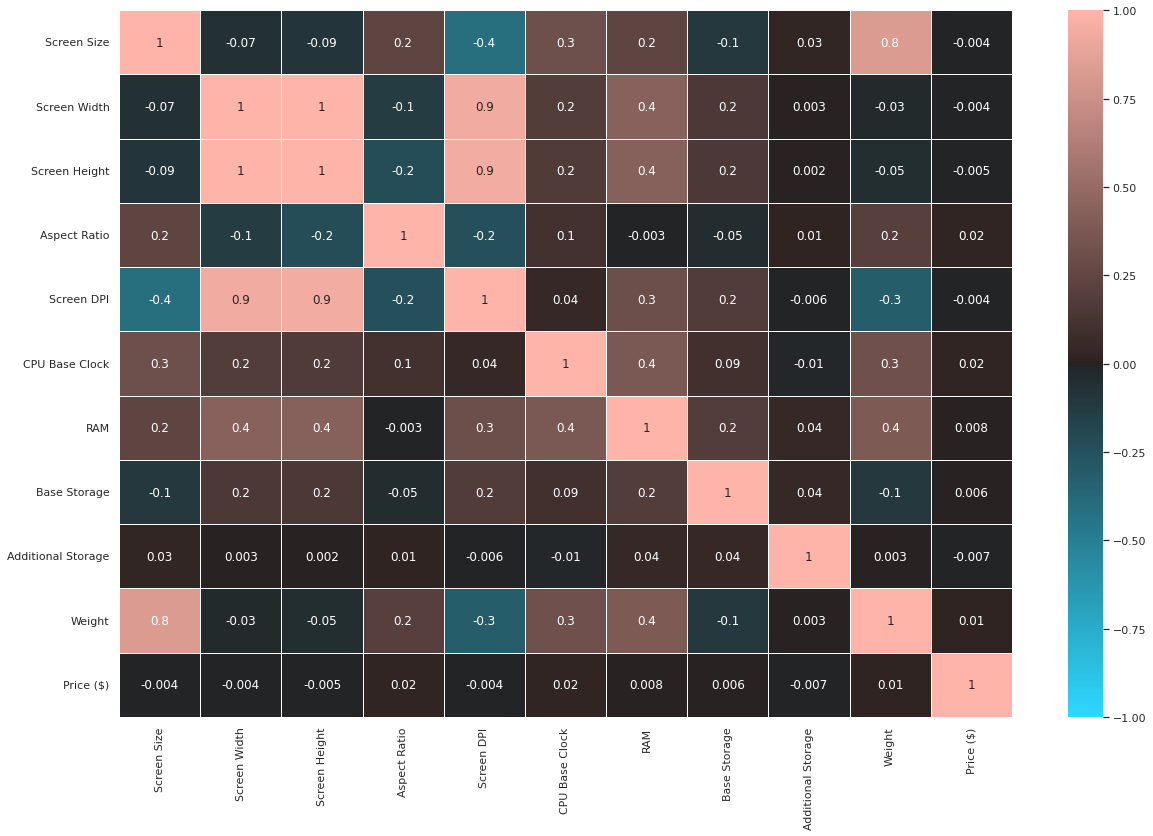

In [19]:
# Correlation matrix
import seaborn as sns; sns.set_theme()
from matplotlib import rcParams

from sklearn.preprocessing import scale
num_corr_df = quantitative
data_reduced = pd.DataFrame(scale(num_corr_df), columns=['Screen Size', 'Screen Width', 'Screen Height', 'Aspect Ratio', 'Screen DPI', 'CPU Base Clock', 'RAM', 'Base Storage', 'Additional Storage', 'Weight','Price ($)'])

rcParams['figure.figsize'] = 20,13
cmap = sns.diverging_palette(220, 20, s=100,l=80, as_cmap=True,center='dark')
fig = sns.heatmap(data_reduced.corr(), annot=True, fmt=".1g",linewidths=.5,vmin=-1, vmax=1,cmap=
                  cmap)



### Conclusion

After conducting PCA, Chi-Square Tests and Lasso Regression for feature importance, I have decided to drop these columns to reduce the dimensionality of the model

In [20]:
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression

df = df.drop(['CPU Series_AMD A12' ,'CPU Series_AMD A4',
 'CPU Series_AMD A6', 'CPU Series_AMD A8','CPU Series_AMD A9',
 'CPU Series_AMD E6' ,'CPU Series_AMD E7','CPU Series_AMD E9',
 'CPU Series_AMD FX 8','CPU Series_AMD FX 9','CPU Series_Atom Z8300',
 'CPU Series_Atom Z8350','CPU Series_Atom Z8550','CPU Series_Celeron N',
 'CPU Series_Celeron U','CPU Series_Core M','CPU Series_Core M M3',
 'CPU Series_Core M M3-6','CPU Series_Core M M3-7',
 'CPU Series_Core M M7-6','CPU Series_Pentium N','CPU Series_Pentium U',
 'CPU Series_Pentium Y','CPU Series_Ryzen 5','CPU Series_Ryzen 7',
 'CPU Series_Xeon 5th gen','CPU Series_Xeon 6th gen','CPU Series_i3',
 'CPU Series_i5','CPU Series_i7','Intel Generation_4th gen',
 'Intel Generation_6th gen','Intel Generation_7th gen',
 'Intel Generation_8th gen','Intel Generation_nan',
 'Intel Core Series Performance Type_HQ',
 'Intel Core Series Performance Type_U',
 'Intel Core Series Performance Type_Y',
 'Intel Core Series Performance Type_nan','Intel Generation_4th gen',
 'Intel Generation_6th gen', 'Intel Generation_7th gen',
 'Intel Generation_8th gen', 'Intel Generation_nan',
 'Intel Core Series Performance Type_HQ',
 'Intel Core Series Performance Type_U',
 'Intel Core Series Performance Type_Y',
 'Intel Core Series Performance Type_nan','AMD Radeon R Model Number_520',
 'AMD Radeon R Model Number_540' ,'AMD Radeon R Model Number_550',
 'AMD Radeon R Model Number_560' ,'AMD Radeon R Model Number_580',
 'AMD Radeon R Model Number_Beema' ,'AMD Radeon R Model Number_Default',
 'AMD Radeon R Model Number_M315', 'AMD Radeon R Model Number_M330',
 'AMD Radeon R Model Number_M360', 'AMD Radeon R Model Number_M365X',
 'AMD Radeon R Model Number_M385' ,'AMD Radeon R Model Number_M420',
 'AMD Radeon R Model Number_M420X' ,'AMD Radeon R Model Number_M430',
 'AMD Radeon R Model Number_M440', 'AMD Radeon R Model Number_M445',
 'AMD Radeon R Model Number_M460' ,'AMD Radeon R Model Number_M465',
 'AMD Radeon R Model Number_nan',
              'GPU Brand_Intel','GPU Brand_Nvidia','GPU Series_GeForce GT',
 'GPU Series_GeForce GTX','GPU Series_HD Graphics',
 'GPU Series_Iris Graphics','GPU Series_Iris Plus Graphics',
 'GPU Series_Iris Pro Graphics','GPU Series_Nvidia','GPU Series_Radeon',
 'GPU Series_Radeon Pro','GPU Series_Radeon R','GPU Series_UHD Graphics',
 'GPU Model_1050M','GPU Model_1060','GPU Model_1070','GPU Model_1070M',
 'GPU Model_1080','GPU Model_150MX','GPU Model_3000M','GPU Model_400',
 'GPU Model_405','GPU Model_455','GPU Model_500','GPU Model_505',
 'GPU Model_510','GPU Model_515','GPU Model_520','GPU Model_530',
 'GPU Model_540','GPU Model_550','GPU Model_555','GPU Model_560',
 'GPU Model_600','GPU Model_615','GPU Model_620','GPU Model_6200',
 'GPU Model_630','GPU Model_640','GPU Model_650','GPU Model_920',
 'GPU Model_920M','GPU Model_920MX','GPU Model_930M','GPU Model_930MX',
 'GPU Model_940M','GPU Model_940MX','GPU Model_950M','GPU Model_960',
 'GPU Model_960M','GPU Model_965M','GPU Model_970M','GPU Model_980',
 'GPU Model_980M','GPU Model_Default','GPU Model_M1000M','GPU Model_M1200',
 'GPU Model_M2000M','GPU Model_M2200','GPU Model_M2200M',
 'GPU Model_M3000M','GPU Model_M500M','GPU Model_M520M','GPU Model_M620',
 'GPU Model_M620M','GPU Model_MX130','GPU Model_MX150','GPU Model_R2',
 'GPU Model_R3','GPU Model_R4','GPU Model_R5','GPU Model_R7',
 'GPU Model_R9','GPU Model_RX','GPU Model_W4190M','GPU Model_W5130M',
 'GPU Model_W6150M', 'CPU Brand_Intel','Screen Width','Screen Height','Aspect Ratio','IPS Check_TN Screen'],axis=1)

print(enc1.get_feature_names_out())
both = pd.merge(cpu, gpu, left_index=True, right_index=True)

enc3 = OneHotEncoder(handle_unknown='error',drop='first').fit(both)

both = pd.DataFrame.sparse.from_spmatrix(enc3.transform(both))
both.columns = enc3.get_feature_names_out(['CPU','GPU'])

df = pd.merge(df, both, left_index=True, right_index=True)

# split data
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

train = train.reset_index()
train = train.drop(['index'],axis=1)

test = test.reset_index()
test = test.drop(['index'],axis=1)

print(
    'Train Data'
)
display(train)

print(
    'Test Data'
)
display(test)

#splitting the data into training and test sets (80:20)
X_train = np.array(train.drop(['Price ($)'],axis=1))
y_train = np.array(train['Price ($)'])

X_test = np.array(test.drop(['Price ($)'],axis=1))
y_test = np.array(test['Price ($)'])








['Brand_Apple' 'Brand_Asus' 'Brand_Chuwi' 'Brand_Dell' 'Brand_Fujitsu'
 'Brand_Google' 'Brand_HP' 'Brand_Huawei' 'Brand_LG' 'Brand_Lenovo'
 'Brand_MSI' 'Brand_Mediacom' 'Brand_Microsoft' 'Brand_Razer'
 'Brand_Samsung' 'Brand_Toshiba' 'Brand_Vero' 'Brand_Xiaomi' 'Type_Gaming'
 'Type_Netbook' 'Type_Notebook' 'Type_Ultrabook' 'Type_Workstation'
 'Touchscreen Check_Touchscreen Available' 'IPS Check_TN Screen'
 'CPU Brand_Intel' 'CPU Series_AMD A12' 'CPU Series_AMD A4'
 'CPU Series_AMD A6' 'CPU Series_AMD A8' 'CPU Series_AMD A9'
 'CPU Series_AMD E6' 'CPU Series_AMD E7' 'CPU Series_AMD E9'
 'CPU Series_AMD FX 8' 'CPU Series_AMD FX 9' 'CPU Series_Atom Z8300'
 'CPU Series_Atom Z8350' 'CPU Series_Atom Z8550' 'CPU Series_Celeron N'
 'CPU Series_Celeron U' 'CPU Series_Core M' 'CPU Series_Core M M3'
 'CPU Series_Core M M3-6' 'CPU Series_Core M M3-7'
 'CPU Series_Core M M7-6' 'CPU Series_Pentium N' 'CPU Series_Pentium U'
 'CPU Series_Pentium Y' 'CPU Series_Ryzen 5' 'CPU Series_Ryzen 7'
 'CPU Series

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Train Data


,Screen Size,Screen DPI,CPU Base Clock,RAM,Base Storage Space Value,Additional Storage Space Value,Weight,Price ($),Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS,Resolution Type,Core Count,Weight Category,CPU_AMD A10-Series 9620P 2.5GHz,CPU_AMD A10-Series A10-9620P 2.5GHz,CPU_AMD A12-Series 9700P 2.5GHz,CPU_AMD A12-Series 9720P 2.7GHz,CPU_AMD A12-Series 9720P 3.6GHz,CPU_AMD A4-Series 7210 2.2GHz,CPU_AMD A6-Series 7310 2GHz,CPU_AMD A6-Series 9220 2.5GHz,CPU_AMD A6-Series 9220 2.9GHz,CPU_AMD A6-Series A6-9220 2.5GHz,CPU_AMD A8-Series 7410 2.2GHz,CPU_AMD A9-Series 9410 2.9GHz,CPU_AMD A9-Series 9420 2.9GHz,CPU_AMD A9-Series 9420 3GHz,CPU_AMD A9-Series A9-9420 3GHz,CPU_AMD E-Series 6110 1.5GHz,CPU_AMD E-Series 7110 1.8GHz,CPU_AMD E-Series 9000 2.2GHz,CPU_AMD E-Series 9000e 1.5GHz,CPU_AMD E-Series E2-6110 1.5GHz,CPU_AMD E-Series E2-9000 2.2GHz,CPU_AMD E-Series E2-9000e 1.5GHz,CPU_AMD FX 8800P 2.1GHz,CPU_AMD FX 9830P 3GHz,CPU_AMD Ryzen 1600 3.2GHz,CPU_AMD Ryzen 1700 3GHz,CPU_Intel Atom X5-Z8350 1.44GHz,CPU_Intel Atom Z8350 1.92GHz,CPU_Intel Atom x5-Z8300 1.44GHz,CPU_Intel Atom x5-Z8350 1.44GHz,CPU_Intel Atom x5-Z8550 1.44GHz,CPU_Intel Celeron Dual Core 3205U 1.5GHz,CPU_Intel Celeron Dual Core 3855U 1.6GHz,CPU_Intel Celeron Dual Core N3050 1.6GHz,CPU_Intel Celeron Dual Core N3060 1.60GHz,CPU_Intel Celeron Dual Core N3060 1.6GHz,CPU_Intel Celeron Dual Core N3350 1.1GHz,CPU_Intel Celeron Dual Core N3350 2.0GHz,CPU_Intel Celeron Dual Core N3350 2GHz,CPU_Intel Celeron Quad Core N3160 1.6GHz,CPU_Intel Celeron Quad Core N3450 1.1GHz,CPU_Intel Celeron Quad Core N3710 1.6GHz,CPU_Intel Core M 1.1GHz,CPU_Intel Core M 1.2GHz,CPU_Intel Core M 6Y30 0.9GHz,CPU_Intel Core M 6Y54 1.1GHz,CPU_Intel Core M 6Y75 1.2GHz,CPU_Intel Core M 7Y30 1.0GHz,CPU_Intel Core M M3-6Y30 0.9GHz,CPU_Intel Core M M7-6Y75 1.2GHz,CPU_Intel Core M m3 1.2GHz,CPU_Intel Core M m3-7Y30 2.2GHz,CPU_Intel Core M m7-6Y75 1.2GHz,CPU_Intel Core i3 6006U 2.0GHz,CPU_Intel Core i3 6006U 2.2GHz,CPU_Intel Core i3 6006U 2GHz,CPU_Intel Core i3 6100U 2.1GHz,CPU_Intel Core i3 6100U 2.3GHz,CPU_Intel Core i3 7100U 2.4GHz,CPU_Intel Core i3 7130U 2.7GHz,CPU_Intel Core i5 1.3GHz,CPU_Intel Core i5 1.6GHz,CPU_Intel Core i5 1.8GHz,CPU_Intel Core i5 2.0GHz,CPU_Intel Core i5 2.3GHz,CPU_Intel Core i5 2.9GHz,CPU_Intel Core i5 3.1GHz,CPU_Intel Core i5 6200U 2.3GHz,CPU_Intel Core i5 6260U 1.8GHz,CPU_Intel Core i5 6300HQ 2.3GHz,CPU_Intel Core i5 6300U 2.4GHz,CPU_Intel Core i5 6440HQ 2.6GHz,CPU_Intel Core i5 7200U 2.50GHz,CPU_Intel Core i5 7200U 2.5GHz,CPU_Intel Core i5 7200U 2.70GHz,CPU_Intel Core i5 7200U 2.7GHz,CPU_Intel Core i5 7300HQ 2.5GHz,CPU_Intel Core i5 7300U 2.6GHz,CPU_Intel Core i5 7440HQ 2.8GHz,CPU_Intel Core i5 7500U 2.7GHz,CPU_Intel Core i5 7Y54 1.2GHz,CPU_Intel Core i5 7Y57 1.2GHz,CPU_Intel Core i5 8250U 1.6GHz,CPU_Intel Core i7 2.2GHz,CPU_Intel Core i7 2.7GHz,CPU_Intel Core i7 2.8GHz,CPU_Intel Core i7 2.9GHz,CPU_Intel Core i7 6500U 2.50GHz,CPU_Intel Core i7 6500U 2.5GHz,CPU_Intel Core i7 6560U 2.2GHz,CPU_Intel Core i7 6600U 2.6GHz,CPU_Intel Core i7 6700HQ 2.6GHz,CPU_Intel Core i7 6820HK 2.7GHz,CPU_Intel Core i7 6820HQ 2.7GHz,CPU_Intel Core i7 6920HQ 2.9GHz,CPU_Intel Core i7 7500U 2.5GHz,CPU_Intel Core i7 7500U 2.7GHz,CPU_Intel Core i7 7560U 2.4GHz,CPU_Intel Core i7 

Test Data


,Screen Size,Screen DPI,CPU Base Clock,RAM,Base Storage Space Value,Additional Storage Space Value,Weight,Price ($),Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS,Resolution Type,Core Count,Weight Category,CPU_AMD A10-Series 9620P 2.5GHz,CPU_AMD A10-Series A10-9620P 2.5GHz,CPU_AMD A12-Series 9700P 2.5GHz,CPU_AMD A12-Series 9720P 2.7GHz,CPU_AMD A12-Series 9720P 3.6GHz,CPU_AMD A4-Series 7210 2.2GHz,CPU_AMD A6-Series 7310 2GHz,CPU_AMD A6-Series 9220 2.5GHz,CPU_AMD A6-Series 9220 2.9GHz,CPU_AMD A6-Series A6-9220 2.5GHz,CPU_AMD A8-Series 7410 2.2GHz,CPU_AMD A9-Series 9410 2.9GHz,CPU_AMD A9-Series 9420 2.9GHz,CPU_AMD A9-Series 9420 3GHz,CPU_AMD A9-Series A9-9420 3GHz,CPU_AMD E-Series 6110 1.5GHz,CPU_AMD E-Series 7110 1.8GHz,CPU_AMD E-Series 9000 2.2GHz,CPU_AMD E-Series 9000e 1.5GHz,CPU_AMD E-Series E2-6110 1.5GHz,CPU_AMD E-Series E2-9000 2.2GHz,CPU_AMD E-Series E2-9000e 1.5GHz,CPU_AMD FX 8800P 2.1GHz,CPU_AMD FX 9830P 3GHz,CPU_AMD Ryzen 1600 3.2GHz,CPU_AMD Ryzen 1700 3GHz,CPU_Intel Atom X5-Z8350 1.44GHz,CPU_Intel Atom Z8350 1.92GHz,CPU_Intel Atom x5-Z8300 1.44GHz,CPU_Intel Atom x5-Z8350 1.44GHz,CPU_Intel Atom x5-Z8550 1.44GHz,CPU_Intel Celeron Dual Core 3205U 1.5GHz,CPU_Intel Celeron Dual Core 3855U 1.6GHz,CPU_Intel Celeron Dual Core N3050 1.6GHz,CPU_Intel Celeron Dual Core N3060 1.60GHz,CPU_Intel Celeron Dual Core N3060 1.6GHz,CPU_Intel Celeron Dual Core N3350 1.1GHz,CPU_Intel Celeron Dual Core N3350 2.0GHz,CPU_Intel Celeron Dual Core N3350 2GHz,CPU_Intel Celeron Quad Core N3160 1.6GHz,CPU_Intel Celeron Quad Core N3450 1.1GHz,CPU_Intel Celeron Quad Core N3710 1.6GHz,CPU_Intel Core M 1.1GHz,CPU_Intel Core M 1.2GHz,CPU_Intel Core M 6Y30 0.9GHz,CPU_Intel Core M 6Y54 1.1GHz,CPU_Intel Core M 6Y75 1.2GHz,CPU_Intel Core M 7Y30 1.0GHz,CPU_Intel Core M M3-6Y30 0.9GHz,CPU_Intel Core M M7-6Y75 1.2GHz,CPU_Intel Core M m3 1.2GHz,CPU_Intel Core M m3-7Y30 2.2GHz,CPU_Intel Core M m7-6Y75 1.2GHz,CPU_Intel Core i3 6006U 2.0GHz,CPU_Intel Core i3 6006U 2.2GHz,CPU_Intel Core i3 6006U 2GHz,CPU_Intel Core i3 6100U 2.1GHz,CPU_Intel Core i3 6100U 2.3GHz,CPU_Intel Core i3 7100U 2.4GHz,CPU_Intel Core i3 7130U 2.7GHz,CPU_Intel Core i5 1.3GHz,CPU_Intel Core i5 1.6GHz,CPU_Intel Core i5 1.8GHz,CPU_Intel Core i5 2.0GHz,CPU_Intel Core i5 2.3GHz,CPU_Intel Core i5 2.9GHz,CPU_Intel Core i5 3.1GHz,CPU_Intel Core i5 6200U 2.3GHz,CPU_Intel Core i5 6260U 1.8GHz,CPU_Intel Core i5 6300HQ 2.3GHz,CPU_Intel Core i5 6300U 2.4GHz,CPU_Intel Core i5 6440HQ 2.6GHz,CPU_Intel Core i5 7200U 2.50GHz,CPU_Intel Core i5 7200U 2.5GHz,CPU_Intel Core i5 7200U 2.70GHz,CPU_Intel Core i5 7200U 2.7GHz,CPU_Intel Core i5 7300HQ 2.5GHz,CPU_Intel Core i5 7300U 2.6GHz,CPU_Intel Core i5 7440HQ 2.8GHz,CPU_Intel Core i5 7500U 2.7GHz,CPU_Intel Core i5 7Y54 1.2GHz,CPU_Intel Core i5 7Y57 1.2GHz,CPU_Intel Core i5 8250U 1.6GHz,CPU_Intel Core i7 2.2GHz,CPU_Intel Core i7 2.7GHz,CPU_Intel Core i7 2.8GHz,CPU_Intel Core i7 2.9GHz,CPU_Intel Core i7 6500U 2.50GHz,CPU_Intel Core i7 6500U 2.5GHz,CPU_Intel Core i7 6560U 2.2GHz,CPU_Intel Core i7 6600U 2.6GHz,CPU_Intel Core i7 6700HQ 2.6GHz,CPU_Intel Core i7 6820HK 2.7GHz,CPU_Intel Core i7 6820HQ 2.7GHz,CPU_Intel Core i7 6920HQ 2.9GHz,CPU_Intel Core i7 7500U 2.5GHz,CPU_Intel Core i7 7500U 2.7GHz,CPU_Intel Core i7 7560U 2.4GHz,CPU_Intel Core i7 

## (C) ML Model Exploration

In [21]:
df.to_csv('df.csv',index=False)

### Baseline Model

Mean Squared Error: 3386500.94
Coefficient of Determination: -0.00
Median Absolute Error: 3386500.94
Mean Absolute Percentage Error: 0.73


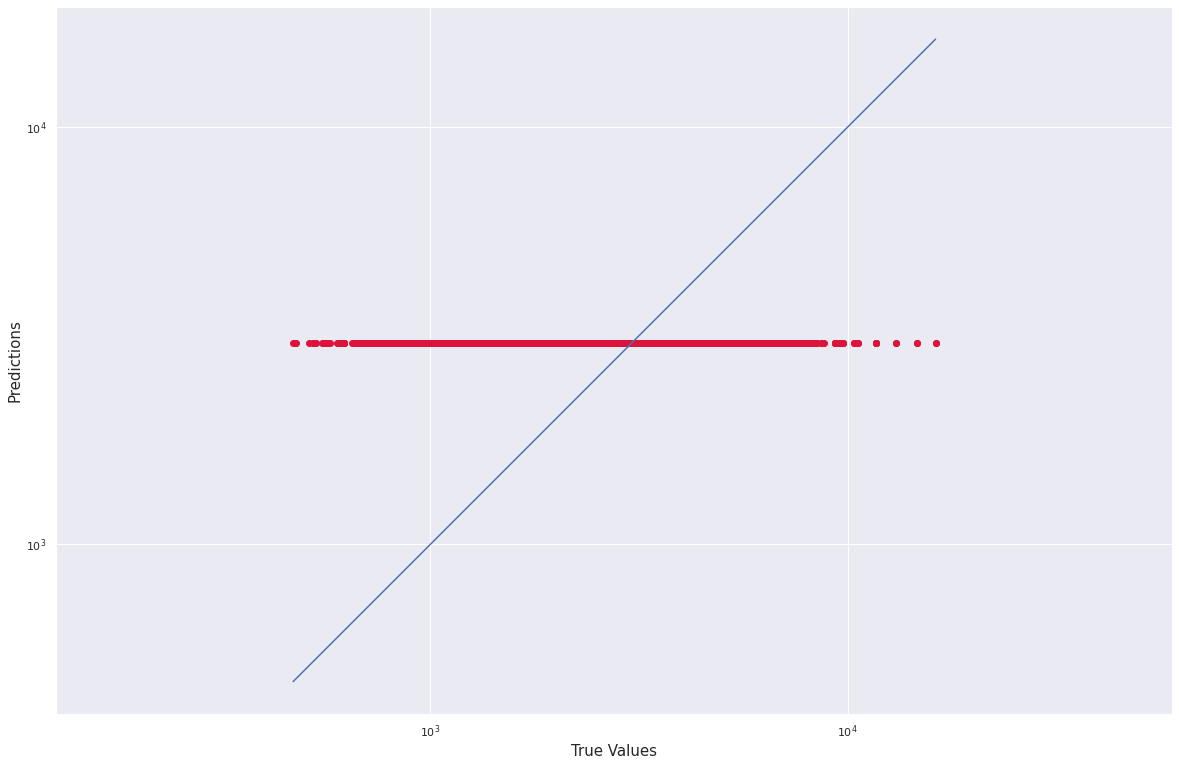

In [22]:
from skimage.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report, r2_score, median_absolute_error, \
    mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics,linear_model


baseline = DummyRegressor()
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)


# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))


plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Linear Regression

Mean Squared Error: 758240.41
Coefficient of Determination: 0.78
Median Absolute Error: 758240.41
Mean Absolute Percentage Error: 0.23


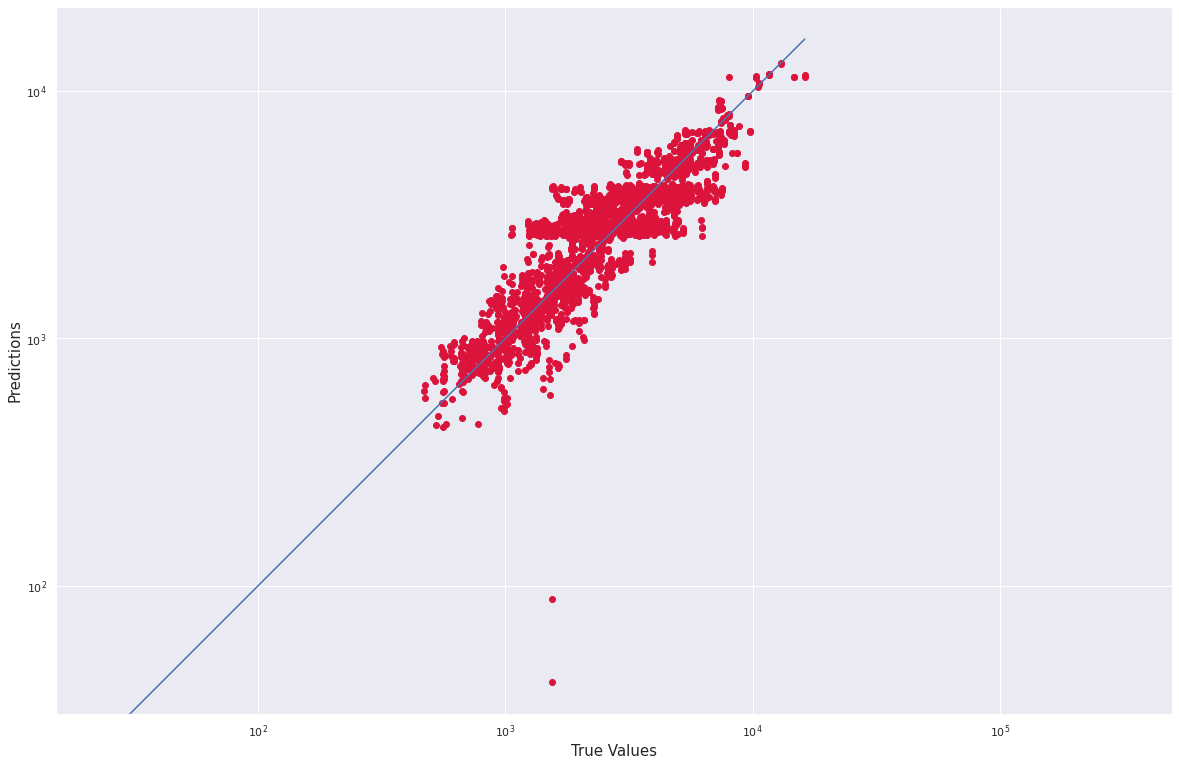

In [23]:
from skimage.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report, r2_score, median_absolute_error, \
    mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics,linear_model

np.set_printoptions(suppress=True)

baseline = linear_model.LinearRegression(copy_X=True, fit_intercept=True,
 n_jobs=1)
baseline.fit(X_train, y_train)
scores = cross_validate(baseline, X_train, y_train, cv=KFold(5),scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

y_pred = baseline.predict(X_test)


# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [24]:
score = pd.DataFrame({scores['test_neg_mean_squared_error'].mean(),scores['train_neg_mean_squared_error'].mean()})
pd.set_option('display.float_format', lambda x: '%.9f' % x)

display(score)

,0
0,-791989.909219261
1,-820571.189033701


### SVM

Mean Squared Error: 3479928.08
Coefficient of Determination: -0.03
Median Absolute Error: 3479928.08
Mean Absolute Percentage Error: 0.62


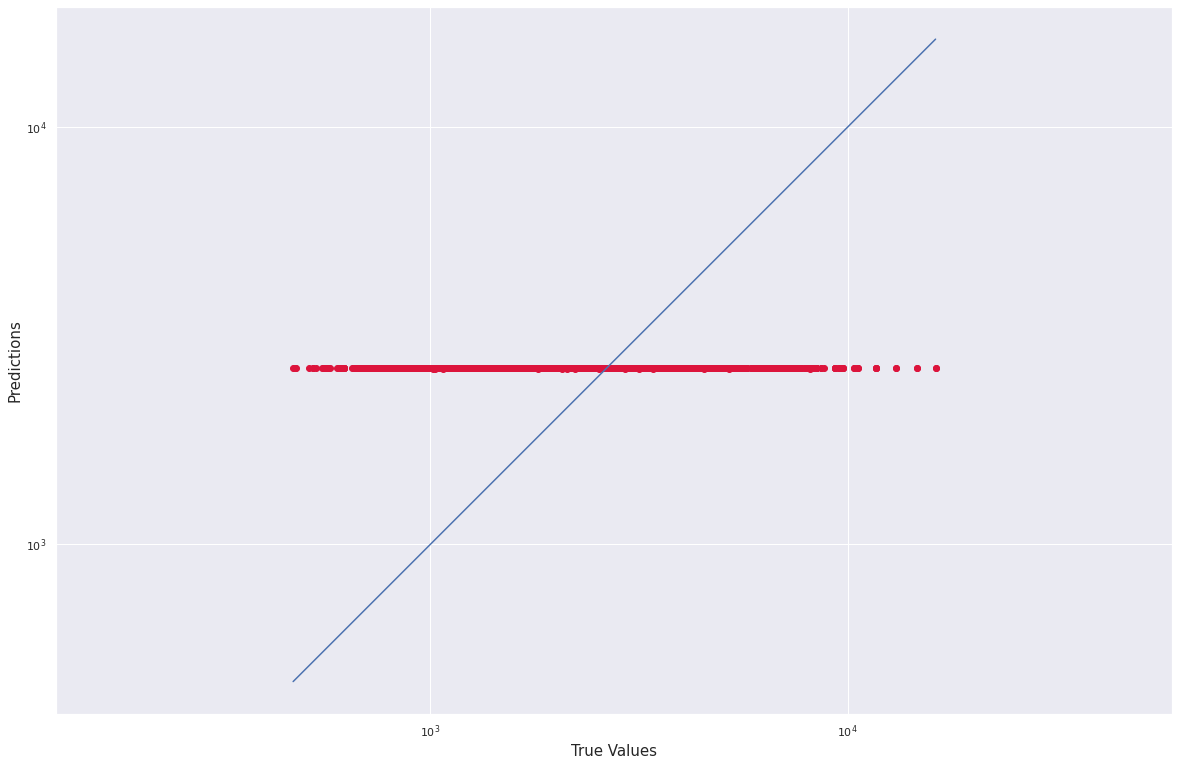

In [25]:
from sklearn.svm import SVR
regr = SVR()

regr.fit(X_train, y_train)
regr.score(X_test, y_test)
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### kNN Regressor

Mean Squared Error: 2498380.32
Coefficient of Determination: 0.26
Median Absolute Error: 2498380.32
Mean Absolute Percentage Error: 0.52


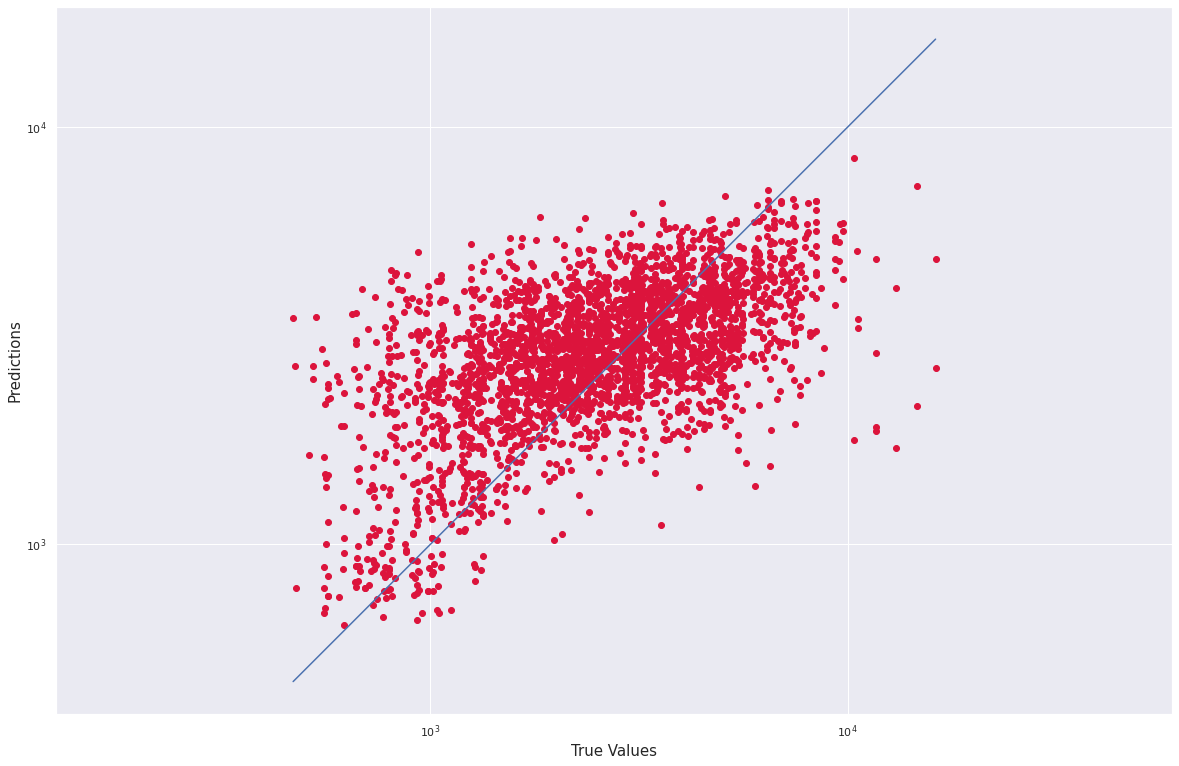

In [26]:
from sklearn.neighbors import ( KNeighborsRegressor)

regr = KNeighborsRegressor(algorithm='auto',
 leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=1, n_neighbors=5,
 p=2, weights='uniform')
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# regr.score(X_test, y_test)

# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Decision Tree


Mean Squared Error: 1220419.60
Coefficient of Determination: 0.64
Median Absolute Error: 1220419.60
Mean Absolute Percentage Error: 0.26


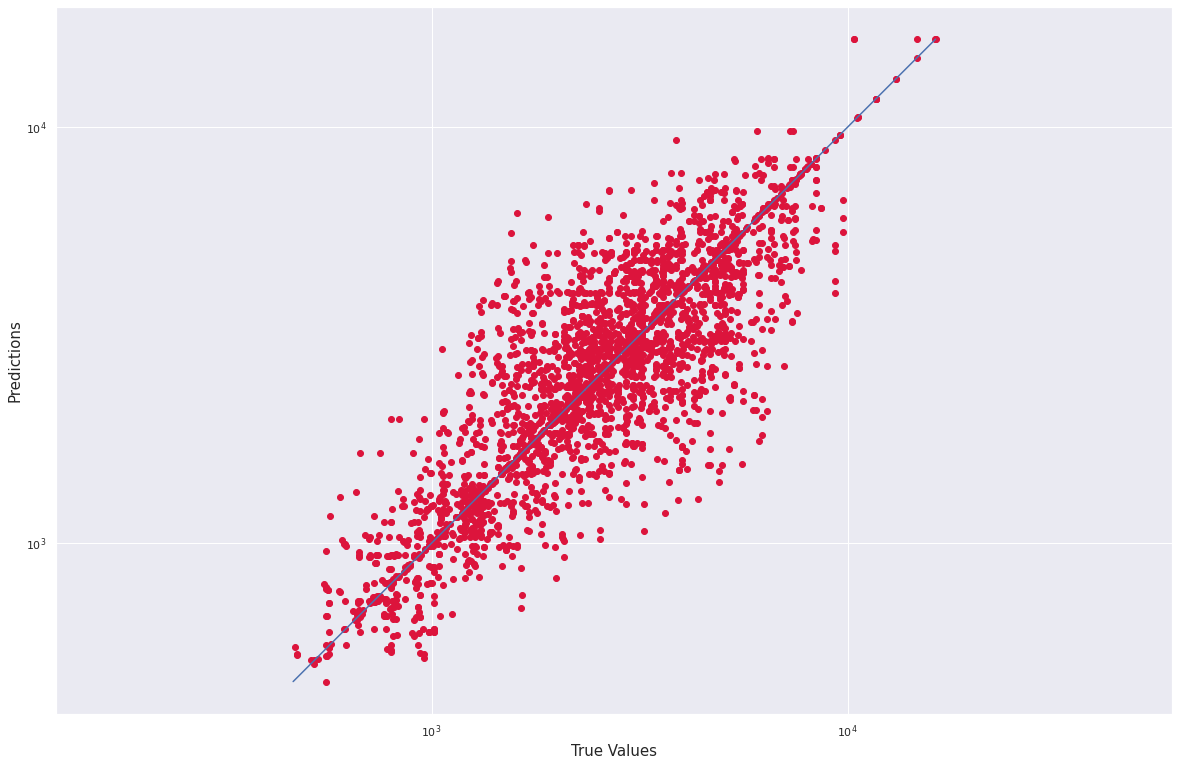

In [27]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor()

scores = cross_validate(regr, X_train, y_train, cv=KFold(5),scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
regr.score(X_test, y_test)
# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))

plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [28]:
score = pd.DataFrame({scores['test_neg_mean_squared_error'].mean(),scores['train_neg_mean_squared_error'].mean()})
pd.set_option('display.float_format', lambda x: '%.9f' % x)

display(score)

,0
0,-1370975.915496464
1,-100153.948977489


### Random Forest

Mean Squared Error: 1236966.92
Coefficient of Determination: 0.63
Median Absolute Error: 1236966.92
Mean Absolute Percentage Error: 0.26


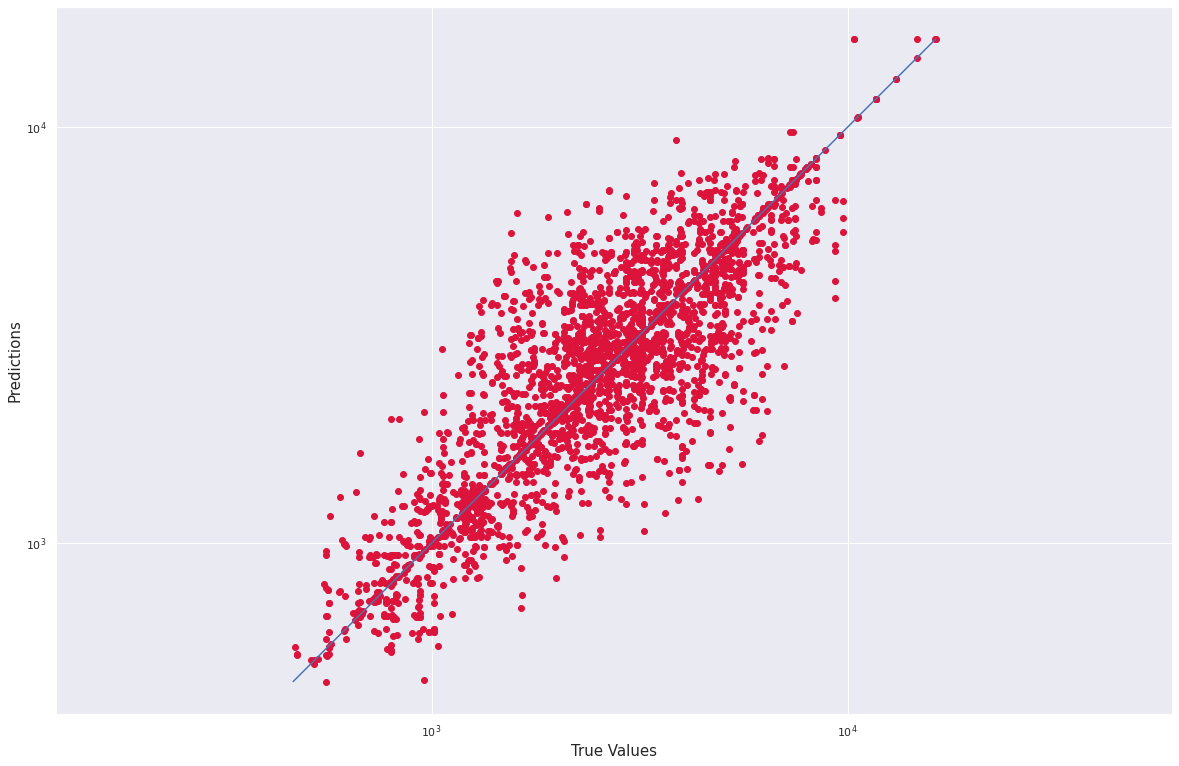

In [29]:
from sklearn.ensemble import (RandomForestRegressor)
rfr = RandomForestRegressor()

regr.fit(X_train, y_train)
scores = cross_validate(regr, X_train, y_train, cv=KFold(5),scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

y_pred = regr.predict(X_test)
regr.score(X_test, y_test)
# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))


plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


In [30]:
score = pd.DataFrame({scores['test_neg_mean_squared_error'].mean(),scores['train_neg_mean_squared_error'].mean()})
pd.set_option('display.float_format', lambda x: '%.9f' % x)

display(score)

,0
0,-1383117.868821759
1,-100153.948977489


### Gradient Boosting

Mean Squared Error: 1191043.99
Coefficient of Determination: 0.65
Median Absolute Error: 1191043.99
Mean Absolute Percentage Error: 0.38


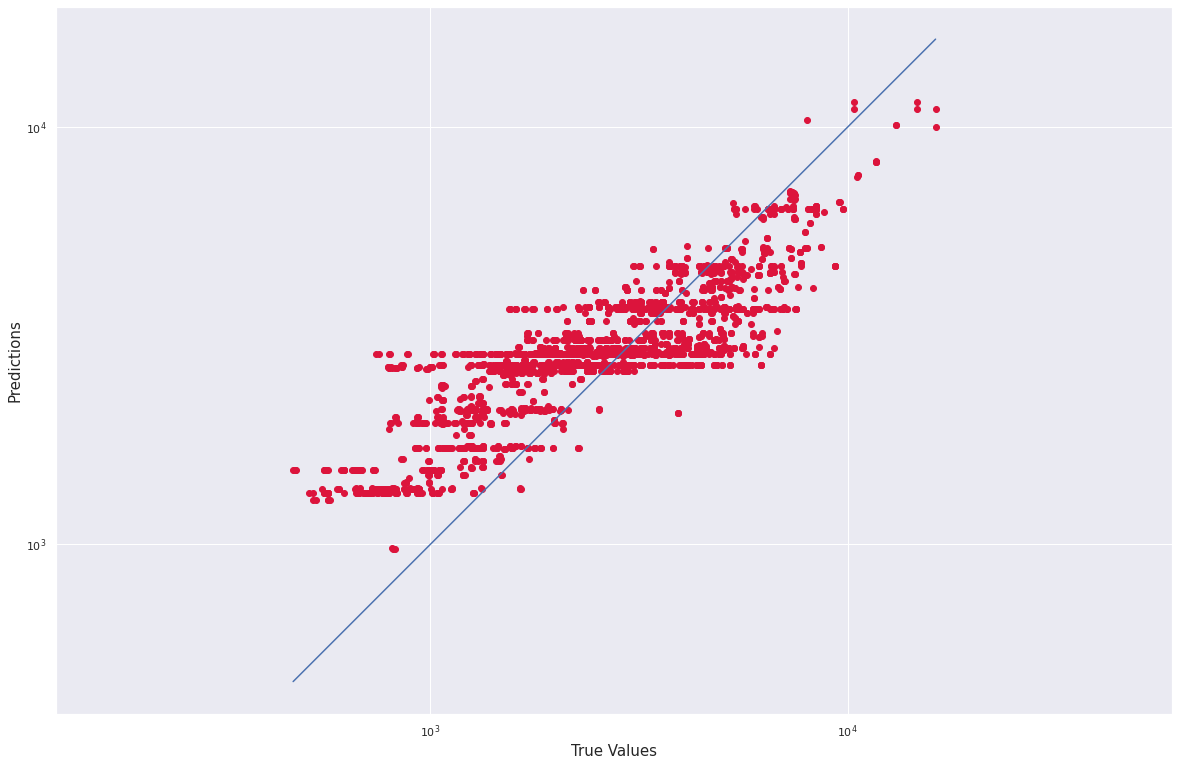

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor(random_state=0)
scores = cross_validate(regr, X_train, y_train, cv=KFold(5),scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
regr.score(X_test, y_test)
# The mean squared error
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of Determination: %.2f" % r2_score(y_test, y_pred))

# The median squared error
print("Median Absolute Error: %.2f" % mean_squared_error(y_test, y_pred))

# The median squared error
print("Mean Absolute Percentage Error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))


plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [32]:
score = pd.DataFrame({scores['test_neg_mean_squared_error'].mean(),scores['train_neg_mean_squared_error'].mean()})
pd.set_option('display.float_format', lambda x: '%.9f' % x)

display(score)

,0
0,-1312526.190729464
1,-1256749.137427649


In [33]:
display(df)

,Screen Size,Screen DPI,CPU Base Clock,RAM,Base Storage Space Value,Additional Storage Space Value,Weight,Price ($),Brand_Apple,Brand_Asus,Brand_Chuwi,Brand_Dell,Brand_Fujitsu,Brand_Google,Brand_HP,Brand_Huawei,Brand_LG,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Razer,Brand_Samsung,Brand_Toshiba,Brand_Vero,Brand_Xiaomi,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,Touchscreen Check_Touchscreen Available,Base Storage Size Type_TB,Base Storage Type_HDD,Base Storage Type_Hybrid,Base Storage Type_SSD,Additional Storage Size Type_TB,Additional Storage Size Type_nan,Additional Storage Type_Hybrid,Additional Storage Type_SSD,Additional Storage Type_nan,Operating System_Chrome OS,Operating System_Linux,Operating System_Mac OS X,Operating System_No OS,Operating System_Windows 10,Operating System_Windows 10 S,Operating System_Windows 7,Operating System_macOS,Resolution Type,Core Count,Weight Category,CPU_AMD A10-Series 9620P 2.5GHz,CPU_AMD A10-Series A10-9620P 2.5GHz,CPU_AMD A12-Series 9700P 2.5GHz,CPU_AMD A12-Series 9720P 2.7GHz,CPU_AMD A12-Series 9720P 3.6GHz,CPU_AMD A4-Series 7210 2.2GHz,CPU_AMD A6-Series 7310 2GHz,CPU_AMD A6-Series 9220 2.5GHz,CPU_AMD A6-Series 9220 2.9GHz,CPU_AMD A6-Series A6-9220 2.5GHz,CPU_AMD A8-Series 7410 2.2GHz,CPU_AMD A9-Series 9410 2.9GHz,CPU_AMD A9-Series 9420 2.9GHz,CPU_AMD A9-Series 9420 3GHz,CPU_AMD A9-Series A9-9420 3GHz,CPU_AMD E-Series 6110 1.5GHz,CPU_AMD E-Series 7110 1.8GHz,CPU_AMD E-Series 9000 2.2GHz,CPU_AMD E-Series 9000e 1.5GHz,CPU_AMD E-Series E2-6110 1.5GHz,CPU_AMD E-Series E2-9000 2.2GHz,CPU_AMD E-Series E2-9000e 1.5GHz,CPU_AMD FX 8800P 2.1GHz,CPU_AMD FX 9830P 3GHz,CPU_AMD Ryzen 1600 3.2GHz,CPU_AMD Ryzen 1700 3GHz,CPU_Intel Atom X5-Z8350 1.44GHz,CPU_Intel Atom Z8350 1.92GHz,CPU_Intel Atom x5-Z8300 1.44GHz,CPU_Intel Atom x5-Z8350 1.44GHz,CPU_Intel Atom x5-Z8550 1.44GHz,CPU_Intel Celeron Dual Core 3205U 1.5GHz,CPU_Intel Celeron Dual Core 3855U 1.6GHz,CPU_Intel Celeron Dual Core N3050 1.6GHz,CPU_Intel Celeron Dual Core N3060 1.60GHz,CPU_Intel Celeron Dual Core N3060 1.6GHz,CPU_Intel Celeron Dual Core N3350 1.1GHz,CPU_Intel Celeron Dual Core N3350 2.0GHz,CPU_Intel Celeron Dual Core N3350 2GHz,CPU_Intel Celeron Quad Core N3160 1.6GHz,CPU_Intel Celeron Quad Core N3450 1.1GHz,CPU_Intel Celeron Quad Core N3710 1.6GHz,CPU_Intel Core M 1.1GHz,CPU_Intel Core M 1.2GHz,CPU_Intel Core M 6Y30 0.9GHz,CPU_Intel Core M 6Y54 1.1GHz,CPU_Intel Core M 6Y75 1.2GHz,CPU_Intel Core M 7Y30 1.0GHz,CPU_Intel Core M M3-6Y30 0.9GHz,CPU_Intel Core M M7-6Y75 1.2GHz,CPU_Intel Core M m3 1.2GHz,CPU_Intel Core M m3-7Y30 2.2GHz,CPU_Intel Core M m7-6Y75 1.2GHz,CPU_Intel Core i3 6006U 2.0GHz,CPU_Intel Core i3 6006U 2.2GHz,CPU_Intel Core i3 6006U 2GHz,CPU_Intel Core i3 6100U 2.1GHz,CPU_Intel Core i3 6100U 2.3GHz,CPU_Intel Core i3 7100U 2.4GHz,CPU_Intel Core i3 7130U 2.7GHz,CPU_Intel Core i5 1.3GHz,CPU_Intel Core i5 1.6GHz,CPU_Intel Core i5 1.8GHz,CPU_Intel Core i5 2.0GHz,CPU_Intel Core i5 2.3GHz,CPU_Intel Core i5 2.9GHz,CPU_Intel Core i5 3.1GHz,CPU_Intel Core i5 6200U 2.3GHz,CPU_Intel Core i5 6260U 1.8GHz,CPU_Intel Core i5 6300HQ 2.3GHz,CPU_Intel Core i5 6300U 2.4GHz,CPU_Intel Core i5 6440HQ 2.6GHz,CPU_Intel Core i5 7200U 2.50GHz,CPU_Intel Core i5 7200U 2.5GHz,CPU_Intel Core i5 7200U 2.70GHz,CPU_Intel Core i5 7200U 2.7GHz,CPU_Intel Core i5 7300HQ 2.5GHz,CPU_Intel Core i5 7300U 2.6GHz,CPU_Intel Core i5 7440HQ 2.8GHz,CPU_Intel Core i5 7500U 2.7GHz,CPU_Intel Core i5 7Y54 1.2GHz,CPU_Intel Core i5 7Y57 1.2GHz,CPU_Intel Core i5 8250U 1.6GHz,CPU_Intel Core i7 2.2GHz,CPU_Intel Core i7 2.7GHz,CPU_Intel Core i7 2.8GHz,CPU_Intel Core i7 2.9GHz,CPU_Intel Core i7 6500U 2.50GHz,CPU_Intel Core i7 6500U 2.5GHz,CPU_Intel Core i7 6560U 2.2GHz,CPU_Intel Core i7 6600U 2.6GHz,CPU_Intel Core i7 6700HQ 2.6GHz,CPU_Intel Core i7 6820HK 2.7GHz,CPU_Intel Core i7 6820HQ 2.7GHz,CPU_Intel Core i7 6920HQ 2.9GHz,CPU_Intel Core i7 7500U 2.5GHz,CPU_Intel Core i7 7500U 2.7GHz,CPU_Intel Core i7 7560U 2.4GHz,CPU_Intel Core i7 

## (D) ML Model Selection & Analysis

### Gradient Boost

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
#define model
model = GradientBoostingRegressor()

# define the grid of values to search
grid = dict()
grid['ccp_alpha'] = np.arange(0,1,0.1)
grid['learning_rate'] = np.arange(0.1,0.5,0.1)
grid['max_depth'] = np.arange(3,9,1)
grid['random_state'] = [42]


# define GridSearch
grid_search = GridSearchCV(model, grid, n_jobs=-1, cv=KFold(5), scoring='neg_mean_squared_error')

# Start GridSearch
result = grid_search.fit(X_train, y_train)


# be sure to change the code a bit
# summarize the best score and configuration
print("Best: %f using %s" % (result.best_score_, result.best_params_))

# summarize all scores that were evaluated
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -789149.720503 using {'ccp_alpha': 0.7000000000000001, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'random_state': 42}
-1312584.464472 (49920.009011) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 42}
-1145035.067029 (42877.576303) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42}
-1042185.820651 (37183.695693) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42}
-964092.761094 (36967.523701) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 42}
-918708.718071 (43566.716040) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 42}
-886279.602988 (49833.531520) with: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42}
-980525.675548 (34640.697053) with: {'ccp_alpha': 0.0, 'learning_rate': 0.2, 'max_depth': 3, 'random_state': 42}
-881765.919000 (39182.354591) with: {'ccp_alpha': 0.0, 'learning_rate':

Random Forest Regressor

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#define model
model = RandomForestRegressor()

# define the grid of values to search
grid = dict()
grid['ccp_alpha'] = np.arange(0,1,0.1)
grid['n_estimators'] = np.arange(10,150,20)
grid['max_depth'] = np.arange(3,9,1)
grid['random_state'] = [42]


# define GridSearch
grid_search = GridSearchCV(model, grid, n_jobs=-1, cv=KFold(5), scoring='neg_mean_squared_error')

# Start GridSearch
result = grid_search.fit(X_train, y_train)


# be sure to change the code a bit
# summarize the best score and configuration
print("Best: %f using %s" % (result.best_score_, result.best_params_))

# summarize all scores that were evaluated
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1809197.907111 using {'ccp_alpha': 0.0, 'max_depth': 8, 'n_estimators': 110, 'random_state': 42}
-2561980.949823 (108738.573100) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 10, 'random_state': 42}
-2542769.272542 (99514.018007) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 30, 'random_state': 42}
-2552379.524927 (95517.485846) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 50, 'random_state': 42}
-2545794.194711 (95566.532534) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 70, 'random_state': 42}
-2544603.220733 (97352.393640) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 90, 'random_state': 42}
-2543812.562851 (98229.303560) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 110, 'random_state': 42}
-2540958.611712 (98575.698663) with: {'ccp_alpha': 0.0, 'max_depth': 3, 'n_estimators': 130, 'random_state': 42}
-2392173.250177 (84987.798793) with: {'ccp_alpha': 0.0, 'max_depth': 4, 'n_estimators': 10, 'random_state': 4

## (E) Questions & Answers

Citations:

www.southampton.ac.uk. (n.d.). Chi Square | Practical Applications of Statistics in the Social Sciences | University of Southampton. [online] Available at: https://www.southampton.ac.uk/passs/full_time_education/bivariate_analysis/chi_square.page#:~:text=A%20chi%2Dsquare%20test%20is [Accessed 14 Jun. 2022].